In [120]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [121]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [122]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [123]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [124]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [125]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [126]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [127]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [128]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [129]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [130]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [131]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [132]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


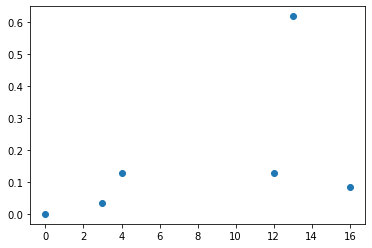

In [133]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [134]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [135]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [136]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [137]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [138]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 4.75 ms, sys: 2 µs, total: 4.76 ms
Wall time: 4.01 ms


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<27x27 sparse matrix of type '<class 'numpy.complex128'>'
	with 36 stored elements in COOrdinate format>

In [139]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [140]:
def R(i,theta):
    
    if i%8 == 0:
        return(exp_gate(0,theta))

    if i%8 == 1:
        return(exp_gate(1,theta))

    if i%8 == 2:
        return(rot_sigma_o(0,1,0,theta))


    if i%8 == 3:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%8 == 4:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    
    if i%8 == 5:
        return(rot_sigma_r(0,1,0,theta))


    if i%8 == 6:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%8 == 7:
        return(rot_sigma_r(1,2,np.pi/2,theta))

        

def S(i,theta):
    
    if i%8 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%8 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
     
    if i%8 == 2:
        return(-1j*sigma_o(0,1,0))

    
    if i%8 == 3:
        return(-1j*sigma_o(0,2,0))

    
    if i%8 == 4:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%8 == 5:
        return(-1j*sigma_r(0,1,0))

    
    if i%8 == 6:
        return(-1j*sigma_r(0,2,0))
    

    if i%8 == 7:
        return(-1j*sigma_r(1,2,np.pi/2))

In [141]:
coeff = 8
stepp = 3000
t_final = 10

In [142]:
expt_value_uu = []
expt_value_vv = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [143]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p

In [ ]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.zeros(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b
        for i in range(L+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(L+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.imag(Y+YY)
        result = np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi
        return psi

            
    def hamiltonian_evolution(theta):
        return expm(-1j*full_ham_matrix.toarray()*theta)

    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.real(np.conj(psi_var)@observable_matrix@psi_var)/norm**2
        
    expt_value_uu.append(expt_value_u)


    

2022-08-16 17:43:29.985742
start 2022-08-16 17:43:30.015453
stop_reduce 2022-08-16 17:43:30.079178
2022-08-16 17:43:30.083033
0
2022-08-16 17:43:30.083086
start 2022-08-16 17:43:30.107382
stop_reduce 2022-08-16 17:43:30.170538
2022-08-16 17:43:30.174304
0.0016666666666666668
2022-08-16 17:43:30.174344
start 2022-08-16 17:43:30.201361
stop_reduce 2022-08-16 17:43:30.267280
2022-08-16 17:43:30.271276
0.0016666666666666668
2022-08-16 17:43:30.271404
start 2022-08-16 17:43:30.304509
stop_reduce 2022-08-16 17:43:30.369956
2022-08-16 17:43:30.373752
0.0033333333333333335
2022-08-16 17:43:30.373798
start 2022-08-16 17:43:30.399484
stop_reduce 2022-08-16 17:43:30.468716
2022-08-16 17:43:30.472619
0.0033333333333333335
2022-08-16 17:43:30.472698
start 2022-08-16 17:43:30.498294
stop_reduce 2022-08-16 17:43:30.564064
2022-08-16 17:43:30.567859
0.005
2022-08-16 17:43:30.567901
start 2022-08-16 17:43:30.593565
stop_reduce 2022-08-16 17:43:30.659227
2022-08-16 17:43:30.662974
0.005
2022-08-16 17:43

start 2022-08-16 17:43:35.773456
stop_reduce 2022-08-16 17:43:35.839346
2022-08-16 17:43:35.843242
0.04833333333333333
2022-08-16 17:43:35.843303
start 2022-08-16 17:43:35.869082
stop_reduce 2022-08-16 17:43:35.932191
2022-08-16 17:43:35.935808
0.04833333333333333
2022-08-16 17:43:35.935845
start 2022-08-16 17:43:35.960727
stop_reduce 2022-08-16 17:43:36.029630
2022-08-16 17:43:36.033871
0.05
2022-08-16 17:43:36.033953
start 2022-08-16 17:43:36.060717
stop_reduce 2022-08-16 17:43:36.130765
2022-08-16 17:43:36.134783
0.05
2022-08-16 17:43:36.134840
start 2022-08-16 17:43:36.161685
stop_reduce 2022-08-16 17:43:36.229203
2022-08-16 17:43:36.233093
0.051666666666666666
2022-08-16 17:43:36.233144
start 2022-08-16 17:43:36.262459
stop_reduce 2022-08-16 17:43:36.329148
2022-08-16 17:43:36.332910
0.051666666666666666
2022-08-16 17:43:36.332957
start 2022-08-16 17:43:36.357449
stop_reduce 2022-08-16 17:43:36.421767
2022-08-16 17:43:36.425436
0.05333333333333334
2022-08-16 17:43:36.425480
start 

start 2022-08-16 17:43:41.458489
stop_reduce 2022-08-16 17:43:41.523481
2022-08-16 17:43:41.527152
0.09499999999999995
2022-08-16 17:43:41.527213
start 2022-08-16 17:43:41.551765
stop_reduce 2022-08-16 17:43:41.615418
2022-08-16 17:43:41.619128
0.09666666666666661
2022-08-16 17:43:41.619183
start 2022-08-16 17:43:41.644811
stop_reduce 2022-08-16 17:43:41.713790
2022-08-16 17:43:41.718214
0.09666666666666661
2022-08-16 17:43:41.718268
start 2022-08-16 17:43:41.745651
stop_reduce 2022-08-16 17:43:41.813458
2022-08-16 17:43:41.817811
0.09833333333333327
2022-08-16 17:43:41.817858
start 2022-08-16 17:43:41.845362
stop_reduce 2022-08-16 17:43:41.914370
2022-08-16 17:43:41.918592
0.09833333333333327
2022-08-16 17:43:41.918636
start 2022-08-16 17:43:41.946465
stop_reduce 2022-08-16 17:43:42.015374
2022-08-16 17:43:42.019549
0.09999999999999994
2022-08-16 17:43:42.019608
start 2022-08-16 17:43:42.047145
stop_reduce 2022-08-16 17:43:42.115066
2022-08-16 17:43:42.119248
0.09999999999999994
2022-

stop_reduce 2022-08-16 17:43:47.525415
2022-08-16 17:43:47.529595
0.14166666666666655
2022-08-16 17:43:47.529650
start 2022-08-16 17:43:47.560244
stop_reduce 2022-08-16 17:43:47.643296
2022-08-16 17:43:47.648528
0.1433333333333332
2022-08-16 17:43:47.648598
start 2022-08-16 17:43:47.682842
stop_reduce 2022-08-16 17:43:47.768337
2022-08-16 17:43:47.772880
0.1433333333333332
2022-08-16 17:43:47.772930
start 2022-08-16 17:43:47.806132
stop_reduce 2022-08-16 17:43:47.896941
2022-08-16 17:43:47.902166
0.14499999999999988
2022-08-16 17:43:47.902363
start 2022-08-16 17:43:47.934201
stop_reduce 2022-08-16 17:43:48.013343
2022-08-16 17:43:48.017262
0.14499999999999988
2022-08-16 17:43:48.017304
start 2022-08-16 17:43:48.043743
stop_reduce 2022-08-16 17:43:48.112485
2022-08-16 17:43:48.117300
0.14666666666666653
2022-08-16 17:43:48.117345
start 2022-08-16 17:43:48.147119
stop_reduce 2022-08-16 17:43:48.223703
2022-08-16 17:43:48.228596
0.14666666666666653
2022-08-16 17:43:48.228646
start 2022-08

start 2022-08-16 17:43:53.619756
stop_reduce 2022-08-16 17:43:53.685405
2022-08-16 17:43:53.689140
0.18999999999999978
2022-08-16 17:43:53.689190
start 2022-08-16 17:43:53.714381
stop_reduce 2022-08-16 17:43:53.779136
2022-08-16 17:43:53.782765
0.19166666666666646
2022-08-16 17:43:53.782800
start 2022-08-16 17:43:53.810727
stop_reduce 2022-08-16 17:43:53.882050
2022-08-16 17:43:53.886071
0.19166666666666646
2022-08-16 17:43:53.886119
start 2022-08-16 17:43:53.911636
stop_reduce 2022-08-16 17:43:53.977441
2022-08-16 17:43:53.981099
0.1933333333333331
2022-08-16 17:43:53.981149
start 2022-08-16 17:43:54.006527
stop_reduce 2022-08-16 17:43:54.072446
2022-08-16 17:43:54.076541
0.1933333333333331
2022-08-16 17:43:54.076587
start 2022-08-16 17:43:54.104568
stop_reduce 2022-08-16 17:43:54.169949
2022-08-16 17:43:54.173678
0.19499999999999978
2022-08-16 17:43:54.173728
start 2022-08-16 17:43:54.199736
stop_reduce 2022-08-16 17:43:54.277331
2022-08-16 17:43:54.282235
0.19499999999999978
2022-08

stop_reduce 2022-08-16 17:43:59.444910
2022-08-16 17:43:59.450013
0.23666666666666636
2022-08-16 17:43:59.450058
start 2022-08-16 17:43:59.479743
stop_reduce 2022-08-16 17:43:59.557379
2022-08-16 17:43:59.562300
0.23833333333333304
2022-08-16 17:43:59.562357
start 2022-08-16 17:43:59.592419
stop_reduce 2022-08-16 17:43:59.677253
2022-08-16 17:43:59.682260
0.23833333333333304
2022-08-16 17:43:59.682311
start 2022-08-16 17:43:59.716248
stop_reduce 2022-08-16 17:43:59.792980
2022-08-16 17:43:59.797844
0.23999999999999969
2022-08-16 17:43:59.797903
start 2022-08-16 17:43:59.827147
stop_reduce 2022-08-16 17:43:59.902936
2022-08-16 17:43:59.906905
0.23999999999999969
2022-08-16 17:43:59.906954
start 2022-08-16 17:43:59.933282
stop_reduce 2022-08-16 17:44:00.000436
2022-08-16 17:44:00.004292
0.24166666666666636
2022-08-16 17:44:00.004333
start 2022-08-16 17:44:00.033686
stop_reduce 2022-08-16 17:44:00.101193
2022-08-16 17:44:00.105197
0.24166666666666636
2022-08-16 17:44:00.105264
start 2022-

stop_reduce 2022-08-16 17:44:05.877599
2022-08-16 17:44:05.882006
0.28499999999999986
2022-08-16 17:44:05.882079
start 2022-08-16 17:44:05.911263
stop_reduce 2022-08-16 17:44:05.988465
2022-08-16 17:44:05.993057
0.28499999999999986
2022-08-16 17:44:05.993111
start 2022-08-16 17:44:06.024284
stop_reduce 2022-08-16 17:44:06.102973
2022-08-16 17:44:06.107378
0.28666666666666657
2022-08-16 17:44:06.107430
start 2022-08-16 17:44:06.137277
stop_reduce 2022-08-16 17:44:06.215193
2022-08-16 17:44:06.219658
0.28666666666666657
2022-08-16 17:44:06.219751
start 2022-08-16 17:44:06.250150
stop_reduce 2022-08-16 17:44:06.327908
2022-08-16 17:44:06.332723
0.2883333333333332
2022-08-16 17:44:06.332790
start 2022-08-16 17:44:06.362989
stop_reduce 2022-08-16 17:44:06.439079
2022-08-16 17:44:06.443372
0.2883333333333332
2022-08-16 17:44:06.443420
start 2022-08-16 17:44:06.473100
stop_reduce 2022-08-16 17:44:06.550667
2022-08-16 17:44:06.555093
0.2899999999999999
2022-08-16 17:44:06.555158
start 2022-08-

stop_reduce 2022-08-16 17:44:12.064460
2022-08-16 17:44:12.068667
0.33333333333333354
2022-08-16 17:44:12.068722
start 2022-08-16 17:44:12.097080
stop_reduce 2022-08-16 17:44:12.172300
2022-08-16 17:44:12.176940
0.33333333333333354
2022-08-16 17:44:12.176995
start 2022-08-16 17:44:12.206399
stop_reduce 2022-08-16 17:44:12.279998
2022-08-16 17:44:12.284254
0.3350000000000002
2022-08-16 17:44:12.284322
start 2022-08-16 17:44:12.313832
stop_reduce 2022-08-16 17:44:12.389129
2022-08-16 17:44:12.393413
0.3350000000000002
2022-08-16 17:44:12.393468
start 2022-08-16 17:44:12.422197
stop_reduce 2022-08-16 17:44:12.498339
2022-08-16 17:44:12.502710
0.3366666666666669
2022-08-16 17:44:12.502789
start 2022-08-16 17:44:12.532261
stop_reduce 2022-08-16 17:44:12.623900
2022-08-16 17:44:12.628473
0.3366666666666669
2022-08-16 17:44:12.628552
start 2022-08-16 17:44:12.660008
stop_reduce 2022-08-16 17:44:12.741329
2022-08-16 17:44:12.745875
0.33833333333333354
2022-08-16 17:44:12.746024
start 2022-08-1

stop_reduce 2022-08-16 17:44:18.588443
2022-08-16 17:44:18.592825
0.38166666666666715
2022-08-16 17:44:18.592876
start 2022-08-16 17:44:18.621758
stop_reduce 2022-08-16 17:44:18.696087
2022-08-16 17:44:18.700333
0.38166666666666715
2022-08-16 17:44:18.700381
start 2022-08-16 17:44:18.729473
stop_reduce 2022-08-16 17:44:18.804359
2022-08-16 17:44:18.808750
0.38333333333333386
2022-08-16 17:44:18.808800
start 2022-08-16 17:44:18.837906
stop_reduce 2022-08-16 17:44:18.912419
2022-08-16 17:44:18.916752
0.38333333333333386
2022-08-16 17:44:18.916802
start 2022-08-16 17:44:18.946132
stop_reduce 2022-08-16 17:44:19.021191
2022-08-16 17:44:19.025611
0.3850000000000005
2022-08-16 17:44:19.025670
start 2022-08-16 17:44:19.054436
stop_reduce 2022-08-16 17:44:19.129742
2022-08-16 17:44:19.134110
0.3850000000000005
2022-08-16 17:44:19.134173
start 2022-08-16 17:44:19.163549
stop_reduce 2022-08-16 17:44:19.238857
2022-08-16 17:44:19.243157
0.3866666666666672
2022-08-16 17:44:19.243218
start 2022-08-

stop_reduce 2022-08-16 17:44:24.940628
2022-08-16 17:44:24.944759
0.4300000000000008
2022-08-16 17:44:24.944804
start 2022-08-16 17:44:24.979228
stop_reduce 2022-08-16 17:44:25.051638
2022-08-16 17:44:25.055719
0.4300000000000008
2022-08-16 17:44:25.055760
start 2022-08-16 17:44:25.083765
stop_reduce 2022-08-16 17:44:25.154948
2022-08-16 17:44:25.159028
0.4316666666666675
2022-08-16 17:44:25.159071
start 2022-08-16 17:44:25.187222
stop_reduce 2022-08-16 17:44:25.260849
2022-08-16 17:44:25.265065
0.4316666666666675
2022-08-16 17:44:25.265106
start 2022-08-16 17:44:25.293668
stop_reduce 2022-08-16 17:44:25.369000
2022-08-16 17:44:25.373118
0.4333333333333342
2022-08-16 17:44:25.373182
start 2022-08-16 17:44:25.401632
stop_reduce 2022-08-16 17:44:25.476030
2022-08-16 17:44:25.480399
0.4333333333333342
2022-08-16 17:44:25.480462
start 2022-08-16 17:44:25.510279
stop_reduce 2022-08-16 17:44:25.585746
2022-08-16 17:44:25.590049
0.43500000000000083
2022-08-16 17:44:25.590097
start 2022-08-16 

2022-08-16 17:44:31.077062
0.47833333333333444
2022-08-16 17:44:31.077106
start 2022-08-16 17:44:31.105291
stop_reduce 2022-08-16 17:44:31.176197
2022-08-16 17:44:31.180224
0.47833333333333444
2022-08-16 17:44:31.180273
start 2022-08-16 17:44:31.208048
stop_reduce 2022-08-16 17:44:31.279288
2022-08-16 17:44:31.283328
0.48000000000000115
2022-08-16 17:44:31.283375
start 2022-08-16 17:44:31.311358
stop_reduce 2022-08-16 17:44:31.382218
2022-08-16 17:44:31.386205
0.48000000000000115
2022-08-16 17:44:31.386251
start 2022-08-16 17:44:31.413895
stop_reduce 2022-08-16 17:44:31.484507
2022-08-16 17:44:31.488421
0.4816666666666678
2022-08-16 17:44:31.488460
start 2022-08-16 17:44:31.515703
stop_reduce 2022-08-16 17:44:31.587068
2022-08-16 17:44:31.591223
0.4816666666666678
2022-08-16 17:44:31.591282
start 2022-08-16 17:44:31.619011
stop_reduce 2022-08-16 17:44:31.690049
2022-08-16 17:44:31.694079
0.4833333333333345
2022-08-16 17:44:31.694122
start 2022-08-16 17:44:31.721987
stop_reduce 2022-08-

stop_reduce 2022-08-16 17:44:37.354073
2022-08-16 17:44:37.358369
0.5266666666666676
2022-08-16 17:44:37.358418
start 2022-08-16 17:44:37.389916
stop_reduce 2022-08-16 17:44:37.468227
2022-08-16 17:44:37.473046
0.5266666666666676
2022-08-16 17:44:37.473103
start 2022-08-16 17:44:37.503409
stop_reduce 2022-08-16 17:44:37.582375
2022-08-16 17:44:37.586951
0.5283333333333343
2022-08-16 17:44:37.587025
start 2022-08-16 17:44:37.617160
stop_reduce 2022-08-16 17:44:37.693662
2022-08-16 17:44:37.698387
0.5283333333333343
2022-08-16 17:44:37.698448
start 2022-08-16 17:44:37.729484
stop_reduce 2022-08-16 17:44:37.806605
2022-08-16 17:44:37.810959
0.5300000000000009
2022-08-16 17:44:37.811008
start 2022-08-16 17:44:37.840976
stop_reduce 2022-08-16 17:44:37.918870
2022-08-16 17:44:37.923221
0.5300000000000009
2022-08-16 17:44:37.923302
start 2022-08-16 17:44:37.953644
stop_reduce 2022-08-16 17:44:38.028949
2022-08-16 17:44:38.033202
0.5316666666666676
2022-08-16 17:44:38.033287
start 2022-08-16 1

stop_reduce 2022-08-16 17:44:43.848122
2022-08-16 17:44:43.852725
0.5750000000000005
2022-08-16 17:44:43.852783
start 2022-08-16 17:44:43.884023
stop_reduce 2022-08-16 17:44:43.961791
2022-08-16 17:44:43.966207
0.5750000000000005
2022-08-16 17:44:43.966253
start 2022-08-16 17:44:43.997325
stop_reduce 2022-08-16 17:44:44.079367
2022-08-16 17:44:44.083970
0.5766666666666671
2022-08-16 17:44:44.084040
start 2022-08-16 17:44:44.117366
stop_reduce 2022-08-16 17:44:44.201592
2022-08-16 17:44:44.206234
0.5766666666666671
2022-08-16 17:44:44.206297
start 2022-08-16 17:44:44.240139
stop_reduce 2022-08-16 17:44:44.327952
2022-08-16 17:44:44.332836
0.5783333333333338
2022-08-16 17:44:44.332900
start 2022-08-16 17:44:44.366039
stop_reduce 2022-08-16 17:44:44.452126
2022-08-16 17:44:44.456745
0.5783333333333338
2022-08-16 17:44:44.456801
start 2022-08-16 17:44:44.492300
stop_reduce 2022-08-16 17:44:44.583021
2022-08-16 17:44:44.588007
0.5800000000000004
2022-08-16 17:44:44.588087
start 2022-08-16 1

stop_reduce 2022-08-16 17:44:50.767810
2022-08-16 17:44:50.772363
0.6233333333333333
2022-08-16 17:44:50.772422
start 2022-08-16 17:44:50.802537
stop_reduce 2022-08-16 17:44:50.879877
2022-08-16 17:44:50.884342
0.6233333333333333
2022-08-16 17:44:50.884398
start 2022-08-16 17:44:50.914572
stop_reduce 2022-08-16 17:44:50.992126
2022-08-16 17:44:50.997139
0.625
2022-08-16 17:44:50.997217
start 2022-08-16 17:44:51.031331
stop_reduce 2022-08-16 17:44:51.112050
2022-08-16 17:44:51.116483
0.625
2022-08-16 17:44:51.116531
start 2022-08-16 17:44:51.147186
stop_reduce 2022-08-16 17:44:51.226044
2022-08-16 17:44:51.230358
0.6266666666666666
2022-08-16 17:44:51.230429
start 2022-08-16 17:44:51.260444
stop_reduce 2022-08-16 17:44:51.336473
2022-08-16 17:44:51.340649
0.6266666666666666
2022-08-16 17:44:51.340691
start 2022-08-16 17:44:51.369882
stop_reduce 2022-08-16 17:44:51.444742
2022-08-16 17:44:51.448927
0.6283333333333333
2022-08-16 17:44:51.448974
start 2022-08-16 17:44:51.479016
stop_reduce

stop_reduce 2022-08-16 17:44:57.326946
2022-08-16 17:44:57.331288
0.6716666666666662
2022-08-16 17:44:57.331434
start 2022-08-16 17:44:57.361852
stop_reduce 2022-08-16 17:44:57.438133
2022-08-16 17:44:57.442348
0.6716666666666662
2022-08-16 17:44:57.442395
start 2022-08-16 17:44:57.472425
stop_reduce 2022-08-16 17:44:57.550119
2022-08-16 17:44:57.554639
0.6733333333333328
2022-08-16 17:44:57.554697
start 2022-08-16 17:44:57.584813
stop_reduce 2022-08-16 17:44:57.661902
2022-08-16 17:44:57.666122
0.6733333333333328
2022-08-16 17:44:57.666174
start 2022-08-16 17:44:57.696429
stop_reduce 2022-08-16 17:44:57.773639
2022-08-16 17:44:57.777890
0.6749999999999995
2022-08-16 17:44:57.777936
start 2022-08-16 17:44:57.807936
stop_reduce 2022-08-16 17:44:57.884625
2022-08-16 17:44:57.889046
0.6749999999999995
2022-08-16 17:44:57.889099
start 2022-08-16 17:44:57.919285
stop_reduce 2022-08-16 17:44:57.995561
2022-08-16 17:44:57.999888
0.6766666666666661
2022-08-16 17:44:57.999937
start 2022-08-16 1

stop_reduce 2022-08-16 17:45:04.128879
2022-08-16 17:45:04.134196
0.7183333333333324
2022-08-16 17:45:04.134261
start 2022-08-16 17:45:04.171078
stop_reduce 2022-08-16 17:45:04.272222
2022-08-16 17:45:04.278644
0.719999999999999
2022-08-16 17:45:04.278720
start 2022-08-16 17:45:04.319227
stop_reduce 2022-08-16 17:45:04.413097
2022-08-16 17:45:04.418040
0.719999999999999
2022-08-16 17:45:04.418096
start 2022-08-16 17:45:04.452656
stop_reduce 2022-08-16 17:45:04.539509
2022-08-16 17:45:04.544217
0.7216666666666657
2022-08-16 17:45:04.544273
start 2022-08-16 17:45:04.578877
stop_reduce 2022-08-16 17:45:04.675961
2022-08-16 17:45:04.681401
0.7216666666666657
2022-08-16 17:45:04.681475
start 2022-08-16 17:45:04.720392
stop_reduce 2022-08-16 17:45:04.814264
2022-08-16 17:45:04.819253
0.7233333333333323
2022-08-16 17:45:04.819342
start 2022-08-16 17:45:04.854367
stop_reduce 2022-08-16 17:45:04.938864
2022-08-16 17:45:04.943626
0.7233333333333323
2022-08-16 17:45:04.943689
start 2022-08-16 17:

stop_reduce 2022-08-16 17:45:10.916447
2022-08-16 17:45:10.920853
0.7666666666666652
2022-08-16 17:45:10.920905
start 2022-08-16 17:45:10.951396
stop_reduce 2022-08-16 17:45:11.029009
2022-08-16 17:45:11.033608
0.7683333333333319
2022-08-16 17:45:11.033671
start 2022-08-16 17:45:11.064119
stop_reduce 2022-08-16 17:45:11.141921
2022-08-16 17:45:11.146298
0.7683333333333319
2022-08-16 17:45:11.146343
start 2022-08-16 17:45:11.176290
stop_reduce 2022-08-16 17:45:11.250850
2022-08-16 17:45:11.255003
0.7699999999999985
2022-08-16 17:45:11.255054
start 2022-08-16 17:45:11.284283
stop_reduce 2022-08-16 17:45:11.360941
2022-08-16 17:45:11.365150
0.7699999999999985
2022-08-16 17:45:11.365213
start 2022-08-16 17:45:11.394995
stop_reduce 2022-08-16 17:45:11.471250
2022-08-16 17:45:11.475580
0.7716666666666652
2022-08-16 17:45:11.475633
start 2022-08-16 17:45:11.505896
stop_reduce 2022-08-16 17:45:11.583342
2022-08-16 17:45:11.587590
0.7716666666666652
2022-08-16 17:45:11.587633
start 2022-08-16 1

stop_reduce 2022-08-16 17:45:17.722820
2022-08-16 17:45:17.728331
0.8149999999999981
2022-08-16 17:45:17.728396
start 2022-08-16 17:45:17.767662
stop_reduce 2022-08-16 17:45:17.867744
2022-08-16 17:45:17.874148
0.8149999999999981
2022-08-16 17:45:17.874232
start 2022-08-16 17:45:17.915434
stop_reduce 2022-08-16 17:45:18.023727
2022-08-16 17:45:18.029349
0.8166666666666647
2022-08-16 17:45:18.029443
start 2022-08-16 17:45:18.072786
stop_reduce 2022-08-16 17:45:18.177350
2022-08-16 17:45:18.182851
0.8166666666666647
2022-08-16 17:45:18.182912
start 2022-08-16 17:45:18.225010
stop_reduce 2022-08-16 17:45:18.338932
2022-08-16 17:45:18.345101
0.8183333333333314
2022-08-16 17:45:18.345207
start 2022-08-16 17:45:18.385568
stop_reduce 2022-08-16 17:45:18.488131
2022-08-16 17:45:18.493717
0.8183333333333314
2022-08-16 17:45:18.493797
start 2022-08-16 17:45:18.533817
stop_reduce 2022-08-16 17:45:18.641094
2022-08-16 17:45:18.646789
0.819999999999998
2022-08-16 17:45:18.646883
start 2022-08-16 17

stop_reduce 2022-08-16 17:45:25.203813
2022-08-16 17:45:25.208454
0.8616666666666642
2022-08-16 17:45:25.208524
start 2022-08-16 17:45:25.240375
stop_reduce 2022-08-16 17:45:25.330382
2022-08-16 17:45:25.334903
0.8633333333333308
2022-08-16 17:45:25.334970
start 2022-08-16 17:45:25.367454
stop_reduce 2022-08-16 17:45:25.452889
2022-08-16 17:45:25.457649
0.8633333333333308
2022-08-16 17:45:25.457717
start 2022-08-16 17:45:25.491402
stop_reduce 2022-08-16 17:45:25.573327
2022-08-16 17:45:25.578043
0.8649999999999975
2022-08-16 17:45:25.578128
start 2022-08-16 17:45:25.610381
stop_reduce 2022-08-16 17:45:25.694251
2022-08-16 17:45:25.699245
0.8649999999999975
2022-08-16 17:45:25.699313
start 2022-08-16 17:45:25.732187
stop_reduce 2022-08-16 17:45:25.816056
2022-08-16 17:45:25.820717
0.8666666666666641
2022-08-16 17:45:25.820806
start 2022-08-16 17:45:25.853549
stop_reduce 2022-08-16 17:45:25.937987
2022-08-16 17:45:25.942836
0.8666666666666641
2022-08-16 17:45:25.942901
start 2022-08-16 1

stop_reduce 2022-08-16 17:45:32.061101
2022-08-16 17:45:32.065519
0.909999999999997
2022-08-16 17:45:32.065582
start 2022-08-16 17:45:32.096153
stop_reduce 2022-08-16 17:45:32.171962
2022-08-16 17:45:32.176162
0.9116666666666637
2022-08-16 17:45:32.176207
start 2022-08-16 17:45:32.206147
stop_reduce 2022-08-16 17:45:32.283065
2022-08-16 17:45:32.287488
0.9116666666666637
2022-08-16 17:45:32.287547
start 2022-08-16 17:45:32.317752
stop_reduce 2022-08-16 17:45:32.395402
2022-08-16 17:45:32.399900
0.9133333333333303
2022-08-16 17:45:32.399959
start 2022-08-16 17:45:32.433309
stop_reduce 2022-08-16 17:45:32.517214
2022-08-16 17:45:32.521972
0.9133333333333303
2022-08-16 17:45:32.522023
start 2022-08-16 17:45:32.554511
stop_reduce 2022-08-16 17:45:32.635884
2022-08-16 17:45:32.640265
0.914999999999997
2022-08-16 17:45:32.640325
start 2022-08-16 17:45:32.670813
stop_reduce 2022-08-16 17:45:32.749087
2022-08-16 17:45:32.753351
0.914999999999997
2022-08-16 17:45:32.753394
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:45:39.203320
2022-08-16 17:45:39.209839
0.9583333333333299
2022-08-16 17:45:39.209915
start 2022-08-16 17:45:39.254551
stop_reduce 2022-08-16 17:45:39.359435
2022-08-16 17:45:39.365142
0.9583333333333299
2022-08-16 17:45:39.365316
start 2022-08-16 17:45:39.403470
stop_reduce 2022-08-16 17:45:39.496063
2022-08-16 17:45:39.501336
0.9599999999999965
2022-08-16 17:45:39.501396
start 2022-08-16 17:45:39.536420
stop_reduce 2022-08-16 17:45:39.621763
2022-08-16 17:45:39.626463
0.9599999999999965
2022-08-16 17:45:39.626519
start 2022-08-16 17:45:39.659944
stop_reduce 2022-08-16 17:45:39.741661
2022-08-16 17:45:39.746106
0.9616666666666632
2022-08-16 17:45:39.746158
start 2022-08-16 17:45:39.778104
stop_reduce 2022-08-16 17:45:39.857869
2022-08-16 17:45:39.862382
0.9616666666666632
2022-08-16 17:45:39.862424
start 2022-08-16 17:45:39.893557
stop_reduce 2022-08-16 17:45:39.973329
2022-08-16 17:45:39.978013
0.9633333333333298
2022-08-16 17:45:39.978078
start 2022-08-16 1

stop_reduce 2022-08-16 17:45:46.222024
2022-08-16 17:45:46.226525
1.0049999999999961
2022-08-16 17:45:46.226594
start 2022-08-16 17:45:46.256785
stop_reduce 2022-08-16 17:45:46.332393
2022-08-16 17:45:46.336774
1.0066666666666628
2022-08-16 17:45:46.336989
start 2022-08-16 17:45:46.366658
stop_reduce 2022-08-16 17:45:46.453841
2022-08-16 17:45:46.459159
1.0066666666666628
2022-08-16 17:45:46.459223
start 2022-08-16 17:45:46.500589
stop_reduce 2022-08-16 17:45:46.589125
2022-08-16 17:45:46.594531
1.0083333333333295
2022-08-16 17:45:46.594601
start 2022-08-16 17:45:46.628853
stop_reduce 2022-08-16 17:45:46.715586
2022-08-16 17:45:46.719915
1.0083333333333295
2022-08-16 17:45:46.719971
start 2022-08-16 17:45:46.754187
stop_reduce 2022-08-16 17:45:46.842548
2022-08-16 17:45:46.846839
1.0099999999999962
2022-08-16 17:45:46.846916
start 2022-08-16 17:45:46.880694
stop_reduce 2022-08-16 17:45:46.958294
2022-08-16 17:45:46.962522
1.0099999999999962
2022-08-16 17:45:46.962586
start 2022-08-16 1

stop_reduce 2022-08-16 17:45:53.994979
2022-08-16 17:45:53.999813
1.0533333333333306
2022-08-16 17:45:53.999870
start 2022-08-16 17:45:54.031827
stop_reduce 2022-08-16 17:45:54.116653
2022-08-16 17:45:54.121082
1.0549999999999973
2022-08-16 17:45:54.121151
start 2022-08-16 17:45:54.152182
stop_reduce 2022-08-16 17:45:54.230591
2022-08-16 17:45:54.234971
1.0549999999999973
2022-08-16 17:45:54.235024
start 2022-08-16 17:45:54.265806
stop_reduce 2022-08-16 17:45:54.347366
2022-08-16 17:45:54.351761
1.056666666666664
2022-08-16 17:45:54.351831
start 2022-08-16 17:45:54.384254
stop_reduce 2022-08-16 17:45:54.466813
2022-08-16 17:45:54.471534
1.056666666666664
2022-08-16 17:45:54.471599
start 2022-08-16 17:45:54.504025
stop_reduce 2022-08-16 17:45:54.585234
2022-08-16 17:45:54.589910
1.0583333333333307
2022-08-16 17:45:54.589969
start 2022-08-16 17:45:54.621746
stop_reduce 2022-08-16 17:45:54.703732
2022-08-16 17:45:54.708831
1.0583333333333307
2022-08-16 17:45:54.708888
start 2022-08-16 17:

stop_reduce 2022-08-16 17:46:00.155185
2022-08-16 17:46:00.159242
1.101666666666665
2022-08-16 17:46:00.159284
start 2022-08-16 17:46:00.188311
stop_reduce 2022-08-16 17:46:00.260257
2022-08-16 17:46:00.264215
1.1033333333333317
2022-08-16 17:46:00.264264
start 2022-08-16 17:46:00.292394
stop_reduce 2022-08-16 17:46:00.365573
2022-08-16 17:46:00.369546
1.1033333333333317
2022-08-16 17:46:00.369597
start 2022-08-16 17:46:00.397987
stop_reduce 2022-08-16 17:46:00.469912
2022-08-16 17:46:00.473884
1.1049999999999984
2022-08-16 17:46:00.473928
start 2022-08-16 17:46:00.502100
stop_reduce 2022-08-16 17:46:00.574860
2022-08-16 17:46:00.578882
1.1049999999999984
2022-08-16 17:46:00.578928
start 2022-08-16 17:46:00.607279
stop_reduce 2022-08-16 17:46:00.679502
2022-08-16 17:46:00.683435
1.1066666666666651
2022-08-16 17:46:00.683483
start 2022-08-16 17:46:00.711835
stop_reduce 2022-08-16 17:46:00.784585
2022-08-16 17:46:00.788519
1.1066666666666651
2022-08-16 17:46:00.788565
start 2022-08-16 17

stop_reduce 2022-08-16 17:46:06.221560
2022-08-16 17:46:06.225663
1.1499999999999995
2022-08-16 17:46:06.225701
start 2022-08-16 17:46:06.254095
stop_reduce 2022-08-16 17:46:06.330624
2022-08-16 17:46:06.334625
1.1516666666666662
2022-08-16 17:46:06.334668
start 2022-08-16 17:46:06.362299
stop_reduce 2022-08-16 17:46:06.434163
2022-08-16 17:46:06.438156
1.1516666666666662
2022-08-16 17:46:06.438200
start 2022-08-16 17:46:06.466668
stop_reduce 2022-08-16 17:46:06.539103
2022-08-16 17:46:06.543037
1.1533333333333329
2022-08-16 17:46:06.543087
start 2022-08-16 17:46:06.571309
stop_reduce 2022-08-16 17:46:06.642411
2022-08-16 17:46:06.646482
1.1533333333333329
2022-08-16 17:46:06.646520
start 2022-08-16 17:46:06.674669
stop_reduce 2022-08-16 17:46:06.746780
2022-08-16 17:46:06.750711
1.1549999999999996
2022-08-16 17:46:06.750754
start 2022-08-16 17:46:06.779027
stop_reduce 2022-08-16 17:46:06.850541
2022-08-16 17:46:06.854484
1.1549999999999996
2022-08-16 17:46:06.854529
start 2022-08-16 1

stop_reduce 2022-08-16 17:46:12.307162
2022-08-16 17:46:12.311210
1.198333333333334
2022-08-16 17:46:12.311262
start 2022-08-16 17:46:12.339786
stop_reduce 2022-08-16 17:46:12.415297
2022-08-16 17:46:12.419317
1.2000000000000006
2022-08-16 17:46:12.419361
start 2022-08-16 17:46:12.447830
stop_reduce 2022-08-16 17:46:12.520981
2022-08-16 17:46:12.525024
1.2000000000000006
2022-08-16 17:46:12.525067
start 2022-08-16 17:46:12.553522
stop_reduce 2022-08-16 17:46:12.626083
2022-08-16 17:46:12.630043
1.2016666666666673
2022-08-16 17:46:12.630086
start 2022-08-16 17:46:12.658548
stop_reduce 2022-08-16 17:46:12.730835
2022-08-16 17:46:12.734795
1.2016666666666673
2022-08-16 17:46:12.734838
start 2022-08-16 17:46:12.762806
stop_reduce 2022-08-16 17:46:12.835139
2022-08-16 17:46:12.839049
1.203333333333334
2022-08-16 17:46:12.839103
start 2022-08-16 17:46:12.867214
stop_reduce 2022-08-16 17:46:12.938256
2022-08-16 17:46:12.942352
1.203333333333334
2022-08-16 17:46:12.942391
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:46:18.376542
2022-08-16 17:46:18.380519
1.2466666666666684
2022-08-16 17:46:18.380557
start 2022-08-16 17:46:18.408827
stop_reduce 2022-08-16 17:46:18.488502
2022-08-16 17:46:18.492447
1.248333333333335
2022-08-16 17:46:18.492493
start 2022-08-16 17:46:18.520929
stop_reduce 2022-08-16 17:46:18.593343
2022-08-16 17:46:18.597362
1.248333333333335
2022-08-16 17:46:18.597405
start 2022-08-16 17:46:18.625765
stop_reduce 2022-08-16 17:46:18.697333
2022-08-16 17:46:18.701169
1.2500000000000018
2022-08-16 17:46:18.701215
start 2022-08-16 17:46:18.729203
stop_reduce 2022-08-16 17:46:18.801144
2022-08-16 17:46:18.805008
1.2500000000000018
2022-08-16 17:46:18.805049
start 2022-08-16 17:46:18.833476
stop_reduce 2022-08-16 17:46:18.905547
2022-08-16 17:46:18.909510
1.2516666666666685
2022-08-16 17:46:18.909562
start 2022-08-16 17:46:18.937684
stop_reduce 2022-08-16 17:46:19.008331
2022-08-16 17:46:19.012293
1.2516666666666685
2022-08-16 17:46:19.012327
start 2022-08-16 17:

stop_reduce 2022-08-16 17:46:24.941696
2022-08-16 17:46:24.947434
1.2950000000000028
2022-08-16 17:46:24.947516
start 2022-08-16 17:46:24.988343
stop_reduce 2022-08-16 17:46:25.089176
2022-08-16 17:46:25.094896
1.2966666666666695
2022-08-16 17:46:25.094991
start 2022-08-16 17:46:25.135428
stop_reduce 2022-08-16 17:46:25.238320
2022-08-16 17:46:25.243933
1.2966666666666695
2022-08-16 17:46:25.244027
start 2022-08-16 17:46:25.284572
stop_reduce 2022-08-16 17:46:25.388744
2022-08-16 17:46:25.394392
1.2983333333333362
2022-08-16 17:46:25.394473
start 2022-08-16 17:46:25.434361
stop_reduce 2022-08-16 17:46:25.537450
2022-08-16 17:46:25.543365
1.2983333333333362
2022-08-16 17:46:25.543456
start 2022-08-16 17:46:25.584498
stop_reduce 2022-08-16 17:46:25.696847
2022-08-16 17:46:25.703023
1.300000000000003
2022-08-16 17:46:25.703109
start 2022-08-16 17:46:25.747092
stop_reduce 2022-08-16 17:46:25.851519
2022-08-16 17:46:25.857157
1.300000000000003
2022-08-16 17:46:25.857230
start 2022-08-16 17:

stop_reduce 2022-08-16 17:46:32.434146
2022-08-16 17:46:32.438606
1.3433333333333373
2022-08-16 17:46:32.438758
start 2022-08-16 17:46:32.468914
stop_reduce 2022-08-16 17:46:32.544770
2022-08-16 17:46:32.548969
1.345000000000004
2022-08-16 17:46:32.549022
start 2022-08-16 17:46:32.582028
stop_reduce 2022-08-16 17:46:32.675817
2022-08-16 17:46:32.680171
1.345000000000004
2022-08-16 17:46:32.680222
start 2022-08-16 17:46:32.709996
stop_reduce 2022-08-16 17:46:32.792163
2022-08-16 17:46:32.797648
1.3466666666666707
2022-08-16 17:46:32.797727
start 2022-08-16 17:46:32.829079
stop_reduce 2022-08-16 17:46:32.909545
2022-08-16 17:46:32.914717
1.3466666666666707
2022-08-16 17:46:32.914766
start 2022-08-16 17:46:32.949946
stop_reduce 2022-08-16 17:46:33.028478
2022-08-16 17:46:33.032892
1.3483333333333374
2022-08-16 17:46:33.032951
start 2022-08-16 17:46:33.064353
stop_reduce 2022-08-16 17:46:33.151066
2022-08-16 17:46:33.155592
1.3483333333333374
2022-08-16 17:46:33.155664
start 2022-08-16 17:

stop_reduce 2022-08-16 17:46:38.900228
2022-08-16 17:46:38.904255
1.3916666666666717
2022-08-16 17:46:38.904300
start 2022-08-16 17:46:38.932598
stop_reduce 2022-08-16 17:46:39.004643
2022-08-16 17:46:39.008698
1.3933333333333384
2022-08-16 17:46:39.008751
start 2022-08-16 17:46:39.037678
stop_reduce 2022-08-16 17:46:39.111928
2022-08-16 17:46:39.116036
1.3933333333333384
2022-08-16 17:46:39.116091
start 2022-08-16 17:46:39.144995
stop_reduce 2022-08-16 17:46:39.218880
2022-08-16 17:46:39.222841
1.3950000000000051
2022-08-16 17:46:39.222880
start 2022-08-16 17:46:39.250930
stop_reduce 2022-08-16 17:46:39.323374
2022-08-16 17:46:39.327383
1.3950000000000051
2022-08-16 17:46:39.327425
start 2022-08-16 17:46:39.355718
stop_reduce 2022-08-16 17:46:39.427597
2022-08-16 17:46:39.431544
1.3966666666666718
2022-08-16 17:46:39.431587
start 2022-08-16 17:46:39.459840
stop_reduce 2022-08-16 17:46:39.533242
2022-08-16 17:46:39.537410
1.3966666666666718
2022-08-16 17:46:39.537459
start 2022-08-16 1

stop_reduce 2022-08-16 17:46:45.056135
2022-08-16 17:46:45.060118
1.4400000000000062
2022-08-16 17:46:45.060163
start 2022-08-16 17:46:45.088383
stop_reduce 2022-08-16 17:46:45.159946
2022-08-16 17:46:45.163932
1.4416666666666729
2022-08-16 17:46:45.163975
start 2022-08-16 17:46:45.192166
stop_reduce 2022-08-16 17:46:45.264796
2022-08-16 17:46:45.268788
1.4416666666666729
2022-08-16 17:46:45.268823
start 2022-08-16 17:46:45.297213
stop_reduce 2022-08-16 17:46:45.369646
2022-08-16 17:46:45.373870
1.4433333333333396
2022-08-16 17:46:45.373924
start 2022-08-16 17:46:45.402918
stop_reduce 2022-08-16 17:46:45.476796
2022-08-16 17:46:45.480945
1.4433333333333396
2022-08-16 17:46:45.480996
start 2022-08-16 17:46:45.510009
stop_reduce 2022-08-16 17:46:45.583414
2022-08-16 17:46:45.587347
1.4450000000000063
2022-08-16 17:46:45.587391
start 2022-08-16 17:46:45.615768
stop_reduce 2022-08-16 17:46:45.688221
2022-08-16 17:46:45.692304
1.4450000000000063
2022-08-16 17:46:45.692354
start 2022-08-16 1

stop_reduce 2022-08-16 17:46:51.495930
2022-08-16 17:46:51.500044
1.4883333333333406
2022-08-16 17:46:51.500099
start 2022-08-16 17:46:51.528485
stop_reduce 2022-08-16 17:46:51.600432
2022-08-16 17:46:51.604410
1.4900000000000073
2022-08-16 17:46:51.604461
start 2022-08-16 17:46:51.632738
stop_reduce 2022-08-16 17:46:51.705243
2022-08-16 17:46:51.709189
1.4900000000000073
2022-08-16 17:46:51.709233
start 2022-08-16 17:46:51.737613
stop_reduce 2022-08-16 17:46:51.809789
2022-08-16 17:46:51.813765
1.491666666666674
2022-08-16 17:46:51.813804
start 2022-08-16 17:46:51.842251
stop_reduce 2022-08-16 17:46:51.916708
2022-08-16 17:46:51.920660
1.491666666666674
2022-08-16 17:46:51.920701
start 2022-08-16 17:46:51.949538
stop_reduce 2022-08-16 17:46:52.023474
2022-08-16 17:46:52.027639
1.4933333333333407
2022-08-16 17:46:52.027687
start 2022-08-16 17:46:52.056128
stop_reduce 2022-08-16 17:46:52.128415
2022-08-16 17:46:52.132607
1.4933333333333407
2022-08-16 17:46:52.132656
start 2022-08-16 17:

stop_reduce 2022-08-16 17:46:57.839721
2022-08-16 17:46:57.843819
1.536666666666675
2022-08-16 17:46:57.843896
start 2022-08-16 17:46:57.872537
stop_reduce 2022-08-16 17:46:57.944899
2022-08-16 17:46:57.948838
1.5383333333333418
2022-08-16 17:46:57.948881
start 2022-08-16 17:46:57.977511
stop_reduce 2022-08-16 17:46:58.050635
2022-08-16 17:46:58.054610
1.5383333333333418
2022-08-16 17:46:58.054655
start 2022-08-16 17:46:58.083264
stop_reduce 2022-08-16 17:46:58.155818
2022-08-16 17:46:58.159769
1.5400000000000085
2022-08-16 17:46:58.159820
start 2022-08-16 17:46:58.188447
stop_reduce 2022-08-16 17:46:58.260058
2022-08-16 17:46:58.263976
1.5400000000000085
2022-08-16 17:46:58.264109
start 2022-08-16 17:46:58.292330
stop_reduce 2022-08-16 17:46:58.365464
2022-08-16 17:46:58.369692
1.5416666666666752
2022-08-16 17:46:58.369765
start 2022-08-16 17:46:58.398033
stop_reduce 2022-08-16 17:46:58.470295
2022-08-16 17:46:58.474245
1.5416666666666752
2022-08-16 17:46:58.474299
start 2022-08-16 17

stop_reduce 2022-08-16 17:47:04.638035
2022-08-16 17:47:04.642085
1.5850000000000095
2022-08-16 17:47:04.642129
start 2022-08-16 17:47:04.677262
stop_reduce 2022-08-16 17:47:04.761886
2022-08-16 17:47:04.766886
1.5866666666666762
2022-08-16 17:47:04.766942
start 2022-08-16 17:47:04.799499
stop_reduce 2022-08-16 17:47:04.884327
2022-08-16 17:47:04.889312
1.5866666666666762
2022-08-16 17:47:04.889355
start 2022-08-16 17:47:04.923278
stop_reduce 2022-08-16 17:47:05.006158
2022-08-16 17:47:05.010971
1.588333333333343
2022-08-16 17:47:05.011010
start 2022-08-16 17:47:05.052058
stop_reduce 2022-08-16 17:47:05.135537
2022-08-16 17:47:05.139574
1.588333333333343
2022-08-16 17:47:05.139614
start 2022-08-16 17:47:05.172398
stop_reduce 2022-08-16 17:47:05.257944
2022-08-16 17:47:05.262125
1.5900000000000096
2022-08-16 17:47:05.262177
start 2022-08-16 17:47:05.295758
stop_reduce 2022-08-16 17:47:05.380854
2022-08-16 17:47:05.385816
1.5900000000000096
2022-08-16 17:47:05.385970
start 2022-08-16 17:

stop_reduce 2022-08-16 17:47:11.679282
2022-08-16 17:47:11.683567
1.633333333333344
2022-08-16 17:47:11.683615
start 2022-08-16 17:47:11.713458
stop_reduce 2022-08-16 17:47:11.791578
2022-08-16 17:47:11.796091
1.6350000000000107
2022-08-16 17:47:11.796140
start 2022-08-16 17:47:11.826892
stop_reduce 2022-08-16 17:47:11.904108
2022-08-16 17:47:11.908339
1.6350000000000107
2022-08-16 17:47:11.908402
start 2022-08-16 17:47:11.937865
stop_reduce 2022-08-16 17:47:12.013979
2022-08-16 17:47:12.018379
1.6366666666666774
2022-08-16 17:47:12.018442
start 2022-08-16 17:47:12.049524
stop_reduce 2022-08-16 17:47:12.128172
2022-08-16 17:47:12.132477
1.6366666666666774
2022-08-16 17:47:12.132527
start 2022-08-16 17:47:12.163064
stop_reduce 2022-08-16 17:47:12.241197
2022-08-16 17:47:12.245449
1.638333333333344
2022-08-16 17:47:12.245490
start 2022-08-16 17:47:12.276330
stop_reduce 2022-08-16 17:47:12.359505
2022-08-16 17:47:12.364248
1.638333333333344
2022-08-16 17:47:12.364291
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:47:18.117730
2022-08-16 17:47:18.121796
1.6816666666666784
2022-08-16 17:47:18.121838
start 2022-08-16 17:47:18.151262
stop_reduce 2022-08-16 17:47:18.232218
2022-08-16 17:47:18.236444
1.6833333333333451
2022-08-16 17:47:18.236514
start 2022-08-16 17:47:18.266185
stop_reduce 2022-08-16 17:47:18.341499
2022-08-16 17:47:18.345756
1.6833333333333451
2022-08-16 17:47:18.345798
start 2022-08-16 17:47:18.375256
stop_reduce 2022-08-16 17:47:18.450023
2022-08-16 17:47:18.454071
1.6850000000000118
2022-08-16 17:47:18.454116
start 2022-08-16 17:47:18.484574
stop_reduce 2022-08-16 17:47:18.568286
2022-08-16 17:47:18.573334
1.6850000000000118
2022-08-16 17:47:18.573407
start 2022-08-16 17:47:18.607145
stop_reduce 2022-08-16 17:47:18.692812
2022-08-16 17:47:18.697680
1.6866666666666785
2022-08-16 17:47:18.697744
start 2022-08-16 17:47:18.734989
stop_reduce 2022-08-16 17:47:18.822382
2022-08-16 17:47:18.826691
1.6866666666666785
2022-08-16 17:47:18.826759
start 2022-08-16 1

stop_reduce 2022-08-16 17:47:24.607991
2022-08-16 17:47:24.612106
1.7300000000000129
2022-08-16 17:47:24.612170
start 2022-08-16 17:47:24.640894
stop_reduce 2022-08-16 17:47:24.714316
2022-08-16 17:47:24.718286
1.7316666666666796
2022-08-16 17:47:24.718335
start 2022-08-16 17:47:24.747069
stop_reduce 2022-08-16 17:47:24.838693
2022-08-16 17:47:24.843344
1.7316666666666796
2022-08-16 17:47:24.843404
start 2022-08-16 17:47:24.878959
stop_reduce 2022-08-16 17:47:24.968862
2022-08-16 17:47:24.973758
1.7333333333333463
2022-08-16 17:47:24.973836
start 2022-08-16 17:47:25.006884
stop_reduce 2022-08-16 17:47:25.089591
2022-08-16 17:47:25.094185
1.7333333333333463
2022-08-16 17:47:25.094244
start 2022-08-16 17:47:25.125944
stop_reduce 2022-08-16 17:47:25.204828
2022-08-16 17:47:25.209037
1.735000000000013
2022-08-16 17:47:25.209083
start 2022-08-16 17:47:25.239345
stop_reduce 2022-08-16 17:47:25.316732
2022-08-16 17:47:25.320970
1.735000000000013
2022-08-16 17:47:25.321015
start 2022-08-16 17:

stop_reduce 2022-08-16 17:47:31.401051
2022-08-16 17:47:31.405329
1.7783333333333473
2022-08-16 17:47:31.405379
start 2022-08-16 17:47:31.445009
stop_reduce 2022-08-16 17:47:31.535738
2022-08-16 17:47:31.540639
1.780000000000014
2022-08-16 17:47:31.540715
start 2022-08-16 17:47:31.577290
stop_reduce 2022-08-16 17:47:31.666776
2022-08-16 17:47:31.671592
1.780000000000014
2022-08-16 17:47:31.671660
start 2022-08-16 17:47:31.705230
stop_reduce 2022-08-16 17:47:31.787524
2022-08-16 17:47:31.791929
1.7816666666666807
2022-08-16 17:47:31.791986
start 2022-08-16 17:47:31.823767
stop_reduce 2022-08-16 17:47:31.903224
2022-08-16 17:47:31.907466
1.7816666666666807
2022-08-16 17:47:31.907519
start 2022-08-16 17:47:31.938165
stop_reduce 2022-08-16 17:47:32.013988
2022-08-16 17:47:32.018058
1.7833333333333474
2022-08-16 17:47:32.018115
start 2022-08-16 17:47:32.047830
stop_reduce 2022-08-16 17:47:32.123521
2022-08-16 17:47:32.127585
1.7833333333333474
2022-08-16 17:47:32.127640
start 2022-08-16 17:

stop_reduce 2022-08-16 17:47:37.677140
2022-08-16 17:47:37.681285
1.8266666666666818
2022-08-16 17:47:37.681325
start 2022-08-16 17:47:37.709662
stop_reduce 2022-08-16 17:47:37.785960
2022-08-16 17:47:37.790083
1.8283333333333485
2022-08-16 17:47:37.790139
start 2022-08-16 17:47:37.820375
stop_reduce 2022-08-16 17:47:37.896179
2022-08-16 17:47:37.900283
1.8283333333333485
2022-08-16 17:47:37.900345
start 2022-08-16 17:47:37.929315
stop_reduce 2022-08-16 17:47:38.003268
2022-08-16 17:47:38.007520
1.8300000000000152
2022-08-16 17:47:38.007567
start 2022-08-16 17:47:38.037942
stop_reduce 2022-08-16 17:47:38.116265
2022-08-16 17:47:38.120844
1.8300000000000152
2022-08-16 17:47:38.120896
start 2022-08-16 17:47:38.151746
stop_reduce 2022-08-16 17:47:38.230399
2022-08-16 17:47:38.234767
1.8316666666666819
2022-08-16 17:47:38.234812
start 2022-08-16 17:47:38.265600
stop_reduce 2022-08-16 17:47:38.344440
2022-08-16 17:47:38.348894
1.8316666666666819
2022-08-16 17:47:38.348939
start 2022-08-16 1

stop_reduce 2022-08-16 17:47:44.562719
2022-08-16 17:47:44.567129
1.8750000000000162
2022-08-16 17:47:44.567178
start 2022-08-16 17:47:44.598328
stop_reduce 2022-08-16 17:47:44.676910
2022-08-16 17:47:44.681324
1.876666666666683
2022-08-16 17:47:44.681396
start 2022-08-16 17:47:44.713015
stop_reduce 2022-08-16 17:47:44.794268
2022-08-16 17:47:44.798955
1.876666666666683
2022-08-16 17:47:44.799006
start 2022-08-16 17:47:44.830481
stop_reduce 2022-08-16 17:47:44.907816
2022-08-16 17:47:44.911989
1.8783333333333496
2022-08-16 17:47:44.912034
start 2022-08-16 17:47:44.942605
stop_reduce 2022-08-16 17:47:45.021415
2022-08-16 17:47:45.025727
1.8783333333333496
2022-08-16 17:47:45.025782
start 2022-08-16 17:47:45.056585
stop_reduce 2022-08-16 17:47:45.137847
2022-08-16 17:47:45.142338
1.8800000000000163
2022-08-16 17:47:45.142407
start 2022-08-16 17:47:45.173771
stop_reduce 2022-08-16 17:47:45.253806
2022-08-16 17:47:45.258221
1.8800000000000163
2022-08-16 17:47:45.258295
start 2022-08-16 17:

stop_reduce 2022-08-16 17:47:51.529126
2022-08-16 17:47:51.533422
1.9233333333333507
2022-08-16 17:47:51.533469
start 2022-08-16 17:47:51.563574
stop_reduce 2022-08-16 17:47:51.639673
2022-08-16 17:47:51.643812
1.9250000000000174
2022-08-16 17:47:51.643852
start 2022-08-16 17:47:51.673649
stop_reduce 2022-08-16 17:47:51.753418
2022-08-16 17:47:51.757923
1.9250000000000174
2022-08-16 17:47:51.757973
start 2022-08-16 17:47:51.789501
stop_reduce 2022-08-16 17:47:51.868893
2022-08-16 17:47:51.873197
1.926666666666684
2022-08-16 17:47:51.873271
start 2022-08-16 17:47:51.904401
stop_reduce 2022-08-16 17:47:51.983840
2022-08-16 17:47:51.988116
1.926666666666684
2022-08-16 17:47:51.988166
start 2022-08-16 17:47:52.020490
stop_reduce 2022-08-16 17:47:52.100187
2022-08-16 17:47:52.104989
1.9283333333333508
2022-08-16 17:47:52.105042
start 2022-08-16 17:47:52.136816
stop_reduce 2022-08-16 17:47:52.213307
2022-08-16 17:47:52.217535
1.9283333333333508
2022-08-16 17:47:52.217599
start 2022-08-16 17:

stop_reduce 2022-08-16 17:47:58.285281
2022-08-16 17:47:58.289545
1.971666666666685
2022-08-16 17:47:58.289590
start 2022-08-16 17:47:58.321959
stop_reduce 2022-08-16 17:47:58.405860
2022-08-16 17:47:58.410187
1.971666666666685
2022-08-16 17:47:58.410232
start 2022-08-16 17:47:58.443811
stop_reduce 2022-08-16 17:47:58.534553
2022-08-16 17:47:58.539285
1.9733333333333518
2022-08-16 17:47:58.539362
start 2022-08-16 17:47:58.577286
stop_reduce 2022-08-16 17:47:58.673461
2022-08-16 17:47:58.678300
1.9733333333333518
2022-08-16 17:47:58.678370
start 2022-08-16 17:47:58.713656
stop_reduce 2022-08-16 17:47:58.803301
2022-08-16 17:47:58.808205
1.9750000000000185
2022-08-16 17:47:58.808301
start 2022-08-16 17:47:58.843123
stop_reduce 2022-08-16 17:47:58.935368
2022-08-16 17:47:58.940250
1.9750000000000185
2022-08-16 17:47:58.940335
start 2022-08-16 17:47:58.977007
stop_reduce 2022-08-16 17:47:59.070518
2022-08-16 17:47:59.075393
1.9766666666666852
2022-08-16 17:47:59.075467
start 2022-08-16 17:

stop_reduce 2022-08-16 17:48:05.292721
2022-08-16 17:48:05.297988
2.0200000000000196
2022-08-16 17:48:05.298043
start 2022-08-16 17:48:05.335208
stop_reduce 2022-08-16 17:48:05.425636
2022-08-16 17:48:05.430339
2.0200000000000196
2022-08-16 17:48:05.430421
start 2022-08-16 17:48:05.462637
stop_reduce 2022-08-16 17:48:05.543674
2022-08-16 17:48:05.548097
2.021666666666686
2022-08-16 17:48:05.548155
start 2022-08-16 17:48:05.582697
stop_reduce 2022-08-16 17:48:05.672546
2022-08-16 17:48:05.677732
2.021666666666686
2022-08-16 17:48:05.677792
start 2022-08-16 17:48:05.713151
stop_reduce 2022-08-16 17:48:05.797960
2022-08-16 17:48:05.803184
2.023333333333353
2022-08-16 17:48:05.803243
start 2022-08-16 17:48:05.838633
stop_reduce 2022-08-16 17:48:05.930416
2022-08-16 17:48:05.934863
2.023333333333353
2022-08-16 17:48:05.934910
start 2022-08-16 17:48:05.965984
stop_reduce 2022-08-16 17:48:06.046070
2022-08-16 17:48:06.051056
2.0250000000000195
2022-08-16 17:48:06.051103
start 2022-08-16 17:48

stop_reduce 2022-08-16 17:48:12.361600
2022-08-16 17:48:12.365820
2.068333333333354
2022-08-16 17:48:12.365871
start 2022-08-16 17:48:12.400693
stop_reduce 2022-08-16 17:48:12.487509
2022-08-16 17:48:12.492531
2.068333333333354
2022-08-16 17:48:12.492581
start 2022-08-16 17:48:12.527267
stop_reduce 2022-08-16 17:48:12.620311
2022-08-16 17:48:12.625480
2.0700000000000207
2022-08-16 17:48:12.625544
start 2022-08-16 17:48:12.660769
stop_reduce 2022-08-16 17:48:12.750632
2022-08-16 17:48:12.755832
2.0700000000000207
2022-08-16 17:48:12.755891
start 2022-08-16 17:48:12.791532
stop_reduce 2022-08-16 17:48:12.883061
2022-08-16 17:48:12.888349
2.071666666666687
2022-08-16 17:48:12.888398
start 2022-08-16 17:48:12.923391
stop_reduce 2022-08-16 17:48:13.012985
2022-08-16 17:48:13.017316
2.071666666666687
2022-08-16 17:48:13.017381
start 2022-08-16 17:48:13.047827
stop_reduce 2022-08-16 17:48:13.125066
2022-08-16 17:48:13.129244
2.073333333333354
2022-08-16 17:48:13.129324
start 2022-08-16 17:48:

stop_reduce 2022-08-16 17:48:18.971241
2022-08-16 17:48:18.975505
2.1166666666666885
2022-08-16 17:48:18.975556
start 2022-08-16 17:48:19.013824
stop_reduce 2022-08-16 17:48:19.101140
2022-08-16 17:48:19.106212
2.1166666666666885
2022-08-16 17:48:19.106268
start 2022-08-16 17:48:19.140982
stop_reduce 2022-08-16 17:48:19.227727
2022-08-16 17:48:19.232461
2.118333333333355
2022-08-16 17:48:19.232521
start 2022-08-16 17:48:19.269640
stop_reduce 2022-08-16 17:48:19.353398
2022-08-16 17:48:19.357803
2.118333333333355
2022-08-16 17:48:19.357865
start 2022-08-16 17:48:19.388993
stop_reduce 2022-08-16 17:48:19.469821
2022-08-16 17:48:19.474834
2.120000000000022
2022-08-16 17:48:19.474886
start 2022-08-16 17:48:19.508687
stop_reduce 2022-08-16 17:48:19.596832
2022-08-16 17:48:19.601166
2.120000000000022
2022-08-16 17:48:19.601221
start 2022-08-16 17:48:19.635830
stop_reduce 2022-08-16 17:48:19.723798
2022-08-16 17:48:19.728086
2.1216666666666884
2022-08-16 17:48:19.728142
start 2022-08-16 17:48

stop_reduce 2022-08-16 17:48:26.823388
2022-08-16 17:48:26.828732
2.1650000000000227
2022-08-16 17:48:26.828789
start 2022-08-16 17:48:26.864834
stop_reduce 2022-08-16 17:48:26.958232
2022-08-16 17:48:26.962883
2.1650000000000227
2022-08-16 17:48:26.963505
start 2022-08-16 17:48:27.000686
stop_reduce 2022-08-16 17:48:27.095643
2022-08-16 17:48:27.104806
2.1666666666666896
2022-08-16 17:48:27.104888
start 2022-08-16 17:48:27.141628
stop_reduce 2022-08-16 17:48:27.231856
2022-08-16 17:48:27.236573
2.1666666666666896
2022-08-16 17:48:27.236665
start 2022-08-16 17:48:27.269285
stop_reduce 2022-08-16 17:48:27.350255
2022-08-16 17:48:27.354571
2.168333333333356
2022-08-16 17:48:27.354618
start 2022-08-16 17:48:27.385673
stop_reduce 2022-08-16 17:48:27.463686
2022-08-16 17:48:27.467985
2.168333333333356
2022-08-16 17:48:27.468027
start 2022-08-16 17:48:27.498976
stop_reduce 2022-08-16 17:48:27.577214
2022-08-16 17:48:27.581517
2.170000000000023
2022-08-16 17:48:27.581578
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:48:34.191270
2022-08-16 17:48:34.195869
2.2133333333333574
2022-08-16 17:48:34.195928
start 2022-08-16 17:48:34.233522
stop_reduce 2022-08-16 17:48:34.328779
2022-08-16 17:48:34.333923
2.2133333333333574
2022-08-16 17:48:34.333981
start 2022-08-16 17:48:34.369610
stop_reduce 2022-08-16 17:48:34.460470
2022-08-16 17:48:34.464755
2.215000000000024
2022-08-16 17:48:34.464799
start 2022-08-16 17:48:34.500638
stop_reduce 2022-08-16 17:48:34.591076
2022-08-16 17:48:34.596157
2.215000000000024
2022-08-16 17:48:34.596221
start 2022-08-16 17:48:34.631792
stop_reduce 2022-08-16 17:48:34.711988
2022-08-16 17:48:34.716393
2.2166666666666908
2022-08-16 17:48:34.716460
start 2022-08-16 17:48:34.747620
stop_reduce 2022-08-16 17:48:34.827566
2022-08-16 17:48:34.832710
2.2166666666666908
2022-08-16 17:48:34.832757
start 2022-08-16 17:48:34.868080
stop_reduce 2022-08-16 17:48:34.957366
2022-08-16 17:48:34.962631
2.2183333333333572
2022-08-16 17:48:34.962696
start 2022-08-16 17:

stop_reduce 2022-08-16 17:48:41.464453
2022-08-16 17:48:41.469321
2.260000000000025
2022-08-16 17:48:41.469507
start 2022-08-16 17:48:41.505957
stop_reduce 2022-08-16 17:48:41.595459
2022-08-16 17:48:41.600285
2.2616666666666916
2022-08-16 17:48:41.600349
start 2022-08-16 17:48:41.638878
stop_reduce 2022-08-16 17:48:41.732056
2022-08-16 17:48:41.739339
2.2616666666666916
2022-08-16 17:48:41.739431
start 2022-08-16 17:48:41.777368
stop_reduce 2022-08-16 17:48:41.867651
2022-08-16 17:48:41.872648
2.2633333333333585
2022-08-16 17:48:41.872721
start 2022-08-16 17:48:41.907377
stop_reduce 2022-08-16 17:48:42.000174
2022-08-16 17:48:42.004970
2.2633333333333585
2022-08-16 17:48:42.005060
start 2022-08-16 17:48:42.041508
stop_reduce 2022-08-16 17:48:42.137250
2022-08-16 17:48:42.142111
2.265000000000025
2022-08-16 17:48:42.142182
start 2022-08-16 17:48:42.178285
stop_reduce 2022-08-16 17:48:42.267158
2022-08-16 17:48:42.271956
2.265000000000025
2022-08-16 17:48:42.272020
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:48:48.335029
2022-08-16 17:48:48.339221
2.3083333333333593
2022-08-16 17:48:48.339261
start 2022-08-16 17:48:48.369394
stop_reduce 2022-08-16 17:48:48.447371
2022-08-16 17:48:48.451472
2.3100000000000263
2022-08-16 17:48:48.451525
start 2022-08-16 17:48:48.481553
stop_reduce 2022-08-16 17:48:48.556364
2022-08-16 17:48:48.560470
2.3100000000000263
2022-08-16 17:48:48.560518
start 2022-08-16 17:48:48.589863
stop_reduce 2022-08-16 17:48:48.664305
2022-08-16 17:48:48.668295
2.3116666666666927
2022-08-16 17:48:48.668336
start 2022-08-16 17:48:48.699761
stop_reduce 2022-08-16 17:48:48.776040
2022-08-16 17:48:48.780193
2.3116666666666927
2022-08-16 17:48:48.780261
start 2022-08-16 17:48:48.810342
stop_reduce 2022-08-16 17:48:48.886090
2022-08-16 17:48:48.890238
2.3133333333333597
2022-08-16 17:48:48.890291
start 2022-08-16 17:48:48.920146
stop_reduce 2022-08-16 17:48:48.996547
2022-08-16 17:48:49.000708
2.3133333333333597
2022-08-16 17:48:49.000748
start 2022-08-16 1

stop_reduce 2022-08-16 17:48:54.833153
2022-08-16 17:48:54.838128
2.356666666666694
2022-08-16 17:48:54.838235
start 2022-08-16 17:48:54.875224
stop_reduce 2022-08-16 17:48:54.967985
2022-08-16 17:48:54.972816
2.3583333333333605
2022-08-16 17:48:54.972881
start 2022-08-16 17:48:55.010786
stop_reduce 2022-08-16 17:48:55.106627
2022-08-16 17:48:55.112319
2.3583333333333605
2022-08-16 17:48:55.112400
start 2022-08-16 17:48:55.149171
stop_reduce 2022-08-16 17:48:55.240379
2022-08-16 17:48:55.245464
2.3600000000000274
2022-08-16 17:48:55.245557
start 2022-08-16 17:48:55.281355
stop_reduce 2022-08-16 17:48:55.374038
2022-08-16 17:48:55.379708
2.3600000000000274
2022-08-16 17:48:55.379802
start 2022-08-16 17:48:55.415764
stop_reduce 2022-08-16 17:48:55.503444
2022-08-16 17:48:55.508215
2.361666666666694
2022-08-16 17:48:55.508285
start 2022-08-16 17:48:55.542398
stop_reduce 2022-08-16 17:48:55.629733
2022-08-16 17:48:55.634523
2.361666666666694
2022-08-16 17:48:55.634603
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:49:02.269432
2022-08-16 17:49:02.274315
2.4050000000000282
2022-08-16 17:49:02.274368
start 2022-08-16 17:49:02.313293
stop_reduce 2022-08-16 17:49:02.405236
2022-08-16 17:49:02.410640
2.4050000000000282
2022-08-16 17:49:02.410731
start 2022-08-16 17:49:02.448410
stop_reduce 2022-08-16 17:49:02.548042
2022-08-16 17:49:02.553129
2.406666666666695
2022-08-16 17:49:02.553197
start 2022-08-16 17:49:02.590724
stop_reduce 2022-08-16 17:49:02.683276
2022-08-16 17:49:02.688188
2.406666666666695
2022-08-16 17:49:02.688256
start 2022-08-16 17:49:02.724182
stop_reduce 2022-08-16 17:49:02.817699
2022-08-16 17:49:02.822767
2.4083333333333616
2022-08-16 17:49:02.822841
start 2022-08-16 17:49:02.858203
stop_reduce 2022-08-16 17:49:02.946004
2022-08-16 17:49:02.950806
2.4083333333333616
2022-08-16 17:49:02.950873
start 2022-08-16 17:49:02.988665
stop_reduce 2022-08-16 17:49:03.080199
2022-08-16 17:49:03.085029
2.4100000000000286
2022-08-16 17:49:03.085102
start 2022-08-16 17:

stop_reduce 2022-08-16 17:49:09.425998
2022-08-16 17:49:09.430282
2.451666666666696
2022-08-16 17:49:09.430348
start 2022-08-16 17:49:09.460728
stop_reduce 2022-08-16 17:49:09.536577
2022-08-16 17:49:09.540716
2.453333333333363
2022-08-16 17:49:09.540770
start 2022-08-16 17:49:09.570847
stop_reduce 2022-08-16 17:49:09.652120
2022-08-16 17:49:09.656325
2.453333333333363
2022-08-16 17:49:09.656388
start 2022-08-16 17:49:09.686695
stop_reduce 2022-08-16 17:49:09.762681
2022-08-16 17:49:09.766929
2.4550000000000294
2022-08-16 17:49:09.766981
start 2022-08-16 17:49:09.797019
stop_reduce 2022-08-16 17:49:09.873220
2022-08-16 17:49:09.877429
2.4550000000000294
2022-08-16 17:49:09.877469
start 2022-08-16 17:49:09.907612
stop_reduce 2022-08-16 17:49:09.984034
2022-08-16 17:49:09.988237
2.4566666666666963
2022-08-16 17:49:09.988307
start 2022-08-16 17:49:10.018439
stop_reduce 2022-08-16 17:49:10.095121
2022-08-16 17:49:10.099360
2.4566666666666963
2022-08-16 17:49:10.099404
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:49:16.593125
2022-08-16 17:49:16.597604
2.5000000000000306
2022-08-16 17:49:16.597670
start 2022-08-16 17:49:16.630006
stop_reduce 2022-08-16 17:49:16.711101
2022-08-16 17:49:16.715516
2.501666666666697
2022-08-16 17:49:16.715671
start 2022-08-16 17:49:16.747637
stop_reduce 2022-08-16 17:49:16.829460
2022-08-16 17:49:16.834295
2.501666666666697
2022-08-16 17:49:16.834376
start 2022-08-16 17:49:16.871659
stop_reduce 2022-08-16 17:49:16.964125
2022-08-16 17:49:16.969237
2.503333333333364
2022-08-16 17:49:16.969318
start 2022-08-16 17:49:17.005394
stop_reduce 2022-08-16 17:49:17.100764
2022-08-16 17:49:17.105655
2.503333333333364
2022-08-16 17:49:17.105713
start 2022-08-16 17:49:17.140801
stop_reduce 2022-08-16 17:49:17.226702
2022-08-16 17:49:17.231326
2.5050000000000305
2022-08-16 17:49:17.231377
start 2022-08-16 17:49:17.264760
stop_reduce 2022-08-16 17:49:17.347027
2022-08-16 17:49:17.351718
2.5050000000000305
2022-08-16 17:49:17.351771
start 2022-08-16 17:49

stop_reduce 2022-08-16 17:49:24.349890
2022-08-16 17:49:24.354055
2.548333333333365
2022-08-16 17:49:24.354124
start 2022-08-16 17:49:24.384823
stop_reduce 2022-08-16 17:49:24.461472
2022-08-16 17:49:24.465767
2.550000000000032
2022-08-16 17:49:24.465837
start 2022-08-16 17:49:24.496158
stop_reduce 2022-08-16 17:49:24.574318
2022-08-16 17:49:24.578556
2.550000000000032
2022-08-16 17:49:24.578623
start 2022-08-16 17:49:24.608825
stop_reduce 2022-08-16 17:49:24.685739
2022-08-16 17:49:24.690081
2.5516666666666983
2022-08-16 17:49:24.690150
start 2022-08-16 17:49:24.720792
stop_reduce 2022-08-16 17:49:24.796540
2022-08-16 17:49:24.800991
2.5516666666666983
2022-08-16 17:49:24.801051
start 2022-08-16 17:49:24.831440
stop_reduce 2022-08-16 17:49:24.951505
2022-08-16 17:49:24.957004
2.553333333333365
2022-08-16 17:49:24.957096
start 2022-08-16 17:49:25.004836
stop_reduce 2022-08-16 17:49:25.127948
2022-08-16 17:49:25.134313
2.553333333333365
2022-08-16 17:49:25.134417
start 2022-08-16 17:49:

start 2022-08-16 17:49:31.655826
stop_reduce 2022-08-16 17:49:31.766198
2022-08-16 17:49:31.771676
2.5966666666666995
2022-08-16 17:49:31.771862
start 2022-08-16 17:49:31.815072
stop_reduce 2022-08-16 17:49:31.931872
2022-08-16 17:49:31.937800
2.5966666666666995
2022-08-16 17:49:31.937868
start 2022-08-16 17:49:31.978886
stop_reduce 2022-08-16 17:49:32.080142
2022-08-16 17:49:32.084988
2.598333333333366
2022-08-16 17:49:32.085080
start 2022-08-16 17:49:32.119249
stop_reduce 2022-08-16 17:49:32.205934
2022-08-16 17:49:32.210461
2.598333333333366
2022-08-16 17:49:32.210520
start 2022-08-16 17:49:32.244615
stop_reduce 2022-08-16 17:49:32.337307
2022-08-16 17:49:32.342545
2.600000000000033
2022-08-16 17:49:32.342609
start 2022-08-16 17:49:32.377591
stop_reduce 2022-08-16 17:49:32.458941
2022-08-16 17:49:32.463460
2.600000000000033
2022-08-16 17:49:32.463512
start 2022-08-16 17:49:32.495279
stop_reduce 2022-08-16 17:49:32.581468
2022-08-16 17:49:32.586643
2.6016666666666994
2022-08-16 17:49

stop_reduce 2022-08-16 17:49:38.451734
2022-08-16 17:49:38.455763
2.6433333333333673
2022-08-16 17:49:38.455802
start 2022-08-16 17:49:38.485080
stop_reduce 2022-08-16 17:49:38.558957
2022-08-16 17:49:38.562889
2.6450000000000338
2022-08-16 17:49:38.562933
start 2022-08-16 17:49:38.592117
stop_reduce 2022-08-16 17:49:38.665255
2022-08-16 17:49:38.669233
2.6450000000000338
2022-08-16 17:49:38.669269
start 2022-08-16 17:49:38.698633
stop_reduce 2022-08-16 17:49:38.772597
2022-08-16 17:49:38.776611
2.6466666666667007
2022-08-16 17:49:38.776664
start 2022-08-16 17:49:38.805954
stop_reduce 2022-08-16 17:49:38.878565
2022-08-16 17:49:38.882566
2.6466666666667007
2022-08-16 17:49:38.882605
start 2022-08-16 17:49:38.912086
stop_reduce 2022-08-16 17:49:38.998061
2022-08-16 17:49:39.002950
2.648333333333367
2022-08-16 17:49:39.003003
start 2022-08-16 17:49:39.036436
stop_reduce 2022-08-16 17:49:39.121083
2022-08-16 17:49:39.125350
2.648333333333367
2022-08-16 17:49:39.125400
start 2022-08-16 17:

stop_reduce 2022-08-16 17:49:45.393986
2022-08-16 17:49:45.398558
2.6916666666667015
2022-08-16 17:49:45.398609
start 2022-08-16 17:49:45.431665
stop_reduce 2022-08-16 17:49:45.517742
2022-08-16 17:49:45.522685
2.6933333333333684
2022-08-16 17:49:45.522776
start 2022-08-16 17:49:45.558662
stop_reduce 2022-08-16 17:49:45.651702
2022-08-16 17:49:45.656928
2.6933333333333684
2022-08-16 17:49:45.656998
start 2022-08-16 17:49:45.694903
stop_reduce 2022-08-16 17:49:45.788813
2022-08-16 17:49:45.793951
2.695000000000035
2022-08-16 17:49:45.794023
start 2022-08-16 17:49:45.832098
stop_reduce 2022-08-16 17:49:45.931466
2022-08-16 17:49:45.937156
2.695000000000035
2022-08-16 17:49:45.937219
start 2022-08-16 17:49:45.976048
stop_reduce 2022-08-16 17:49:46.076613
2022-08-16 17:49:46.082011
2.696666666666702
2022-08-16 17:49:46.082074
start 2022-08-16 17:49:46.126950
stop_reduce 2022-08-16 17:49:46.238107
2022-08-16 17:49:46.243391
2.696666666666702
2022-08-16 17:49:46.243569
start 2022-08-16 17:49

stop_reduce 2022-08-16 17:49:52.481538
2022-08-16 17:49:52.486471
2.740000000000036
2022-08-16 17:49:52.486531
start 2022-08-16 17:49:52.519678
stop_reduce 2022-08-16 17:49:52.605800
2022-08-16 17:49:52.610924
2.7416666666667027
2022-08-16 17:49:52.610973
start 2022-08-16 17:49:52.645569
stop_reduce 2022-08-16 17:49:52.732761
2022-08-16 17:49:52.737809
2.7416666666667027
2022-08-16 17:49:52.737870
start 2022-08-16 17:49:52.772625
stop_reduce 2022-08-16 17:49:52.863778
2022-08-16 17:49:52.868110
2.7433333333333696
2022-08-16 17:49:52.868174
start 2022-08-16 17:49:52.903939
stop_reduce 2022-08-16 17:49:52.995850
2022-08-16 17:49:53.000954
2.7433333333333696
2022-08-16 17:49:53.001017
start 2022-08-16 17:49:53.036659
stop_reduce 2022-08-16 17:49:53.118686
2022-08-16 17:49:53.122895
2.745000000000036
2022-08-16 17:49:53.122966
start 2022-08-16 17:49:53.160287
stop_reduce 2022-08-16 17:49:53.236605
2022-08-16 17:49:53.240831
2.745000000000036
2022-08-16 17:49:53.240885
start 2022-08-16 17:4

stop_reduce 2022-08-16 17:49:59.802355
2022-08-16 17:49:59.807572
2.7883333333333704
2022-08-16 17:49:59.807730
start 2022-08-16 17:49:59.843397
stop_reduce 2022-08-16 17:49:59.932733
2022-08-16 17:49:59.937007
2.7900000000000373
2022-08-16 17:49:59.937065
start 2022-08-16 17:49:59.968455
stop_reduce 2022-08-16 17:50:00.046904
2022-08-16 17:50:00.051199
2.7900000000000373
2022-08-16 17:50:00.051364
start 2022-08-16 17:50:00.084546
stop_reduce 2022-08-16 17:50:00.170516
2022-08-16 17:50:00.175867
2.791666666666704
2022-08-16 17:50:00.176079
start 2022-08-16 17:50:00.213369
stop_reduce 2022-08-16 17:50:00.309357
2022-08-16 17:50:00.313809
2.791666666666704
2022-08-16 17:50:00.313854
start 2022-08-16 17:50:00.345525
stop_reduce 2022-08-16 17:50:00.428313
2022-08-16 17:50:00.433372
2.7933333333333707
2022-08-16 17:50:00.433433
start 2022-08-16 17:50:00.468833
stop_reduce 2022-08-16 17:50:00.569707
2022-08-16 17:50:00.574374
2.7933333333333707
2022-08-16 17:50:00.574437
start 2022-08-16 17:

stop_reduce 2022-08-16 17:50:07.208671
2022-08-16 17:50:07.212733
2.836666666666705
2022-08-16 17:50:07.212779
start 2022-08-16 17:50:07.242300
stop_reduce 2022-08-16 17:50:07.316664
2022-08-16 17:50:07.320691
2.836666666666705
2022-08-16 17:50:07.320735
start 2022-08-16 17:50:07.352106
stop_reduce 2022-08-16 17:50:07.431508
2022-08-16 17:50:07.435754
2.8383333333333716
2022-08-16 17:50:07.435805
start 2022-08-16 17:50:07.467272
stop_reduce 2022-08-16 17:50:07.547282
2022-08-16 17:50:07.551595
2.8383333333333716
2022-08-16 17:50:07.551663
start 2022-08-16 17:50:07.582887
stop_reduce 2022-08-16 17:50:07.662402
2022-08-16 17:50:07.666744
2.8400000000000385
2022-08-16 17:50:07.666808
start 2022-08-16 17:50:07.697966
stop_reduce 2022-08-16 17:50:07.777088
2022-08-16 17:50:07.781803
2.8400000000000385
2022-08-16 17:50:07.781855
start 2022-08-16 17:50:07.814156
stop_reduce 2022-08-16 17:50:07.896092
2022-08-16 17:50:07.900573
2.841666666666705
2022-08-16 17:50:07.900621
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:50:13.996846
2022-08-16 17:50:14.001465
2.883333333333373
2022-08-16 17:50:14.001526
start 2022-08-16 17:50:14.032595
stop_reduce 2022-08-16 17:50:14.111588
2022-08-16 17:50:14.116134
2.8850000000000393
2022-08-16 17:50:14.116205
start 2022-08-16 17:50:14.149028
stop_reduce 2022-08-16 17:50:14.229373
2022-08-16 17:50:14.233846
2.8850000000000393
2022-08-16 17:50:14.233896
start 2022-08-16 17:50:14.265488
stop_reduce 2022-08-16 17:50:14.343917
2022-08-16 17:50:14.348291
2.8866666666667062
2022-08-16 17:50:14.348456
start 2022-08-16 17:50:14.379466
stop_reduce 2022-08-16 17:50:14.460477
2022-08-16 17:50:14.465117
2.8866666666667062
2022-08-16 17:50:14.465204
start 2022-08-16 17:50:14.497719
stop_reduce 2022-08-16 17:50:14.578570
2022-08-16 17:50:14.583005
2.8883333333333727
2022-08-16 17:50:14.583070
start 2022-08-16 17:50:14.614984
stop_reduce 2022-08-16 17:50:14.700820
2022-08-16 17:50:14.705505
2.8883333333333727
2022-08-16 17:50:14.705561
start 2022-08-16 17

stop_reduce 2022-08-16 17:50:20.852188
2022-08-16 17:50:20.856720
2.931666666666707
2022-08-16 17:50:20.856766
start 2022-08-16 17:50:20.889238
stop_reduce 2022-08-16 17:50:20.969874
2022-08-16 17:50:20.974306
2.933333333333374
2022-08-16 17:50:20.974379
start 2022-08-16 17:50:21.006206
stop_reduce 2022-08-16 17:50:21.084972
2022-08-16 17:50:21.089249
2.933333333333374
2022-08-16 17:50:21.089393
start 2022-08-16 17:50:21.120166
stop_reduce 2022-08-16 17:50:21.197816
2022-08-16 17:50:21.202430
2.9350000000000405
2022-08-16 17:50:21.202539
start 2022-08-16 17:50:21.234556
stop_reduce 2022-08-16 17:50:21.315931
2022-08-16 17:50:21.320351
2.9350000000000405
2022-08-16 17:50:21.320413
start 2022-08-16 17:50:21.352548
stop_reduce 2022-08-16 17:50:21.431657
2022-08-16 17:50:21.435908
2.9366666666667074
2022-08-16 17:50:21.435971
start 2022-08-16 17:50:21.467382
stop_reduce 2022-08-16 17:50:21.546126
2022-08-16 17:50:21.550413
2.9366666666667074
2022-08-16 17:50:21.550468
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:50:27.577516
2022-08-16 17:50:27.581857
2.9800000000000417
2022-08-16 17:50:27.581912
start 2022-08-16 17:50:27.613550
stop_reduce 2022-08-16 17:50:27.693153
2022-08-16 17:50:27.697379
2.981666666666708
2022-08-16 17:50:27.697421
start 2022-08-16 17:50:27.728237
stop_reduce 2022-08-16 17:50:27.806505
2022-08-16 17:50:27.810802
2.981666666666708
2022-08-16 17:50:27.810848
start 2022-08-16 17:50:27.841786
stop_reduce 2022-08-16 17:50:27.918604
2022-08-16 17:50:27.922758
2.983333333333375
2022-08-16 17:50:27.922810
start 2022-08-16 17:50:27.954345
stop_reduce 2022-08-16 17:50:28.035672
2022-08-16 17:50:28.040148
2.983333333333375
2022-08-16 17:50:28.040208
start 2022-08-16 17:50:28.071812
stop_reduce 2022-08-16 17:50:28.153039
2022-08-16 17:50:28.157436
2.9850000000000416
2022-08-16 17:50:28.157500
start 2022-08-16 17:50:28.191946
stop_reduce 2022-08-16 17:50:28.274817
2022-08-16 17:50:28.279207
2.9850000000000416
2022-08-16 17:50:28.279262
start 2022-08-16 17:50

stop_reduce 2022-08-16 17:50:34.596082
2022-08-16 17:50:34.600745
3.028333333333376
2022-08-16 17:50:34.600791
start 2022-08-16 17:50:34.633715
stop_reduce 2022-08-16 17:50:34.715710
2022-08-16 17:50:34.720131
3.030000000000043
2022-08-16 17:50:34.720186
start 2022-08-16 17:50:34.751865
stop_reduce 2022-08-16 17:50:34.831572
2022-08-16 17:50:34.835869
3.030000000000043
2022-08-16 17:50:34.835938
start 2022-08-16 17:50:34.866684
stop_reduce 2022-08-16 17:50:34.947806
2022-08-16 17:50:34.952106
3.0316666666667094
2022-08-16 17:50:34.952165
start 2022-08-16 17:50:34.985657
stop_reduce 2022-08-16 17:50:35.072752
2022-08-16 17:50:35.077582
3.0316666666667094
2022-08-16 17:50:35.077651
start 2022-08-16 17:50:35.111566
stop_reduce 2022-08-16 17:50:35.198020
2022-08-16 17:50:35.202719
3.0333333333333763
2022-08-16 17:50:35.202808
start 2022-08-16 17:50:35.235904
stop_reduce 2022-08-16 17:50:35.319938
2022-08-16 17:50:35.324650
3.0333333333333763
2022-08-16 17:50:35.324731
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:50:41.652725
2022-08-16 17:50:41.657027
3.0766666666667106
2022-08-16 17:50:41.657087
start 2022-08-16 17:50:41.687754
stop_reduce 2022-08-16 17:50:41.765349
2022-08-16 17:50:41.769383
3.078333333333377
2022-08-16 17:50:41.769427
start 2022-08-16 17:50:41.799953
stop_reduce 2022-08-16 17:50:41.878514
2022-08-16 17:50:41.882826
3.078333333333377
2022-08-16 17:50:41.882867
start 2022-08-16 17:50:41.913754
stop_reduce 2022-08-16 17:50:41.990205
2022-08-16 17:50:41.994269
3.080000000000044
2022-08-16 17:50:41.994316
start 2022-08-16 17:50:42.024397
stop_reduce 2022-08-16 17:50:42.100855
2022-08-16 17:50:42.105039
3.080000000000044
2022-08-16 17:50:42.105089
start 2022-08-16 17:50:42.135221
stop_reduce 2022-08-16 17:50:42.209871
2022-08-16 17:50:42.214017
3.0816666666667105
2022-08-16 17:50:42.214110
start 2022-08-16 17:50:42.244171
stop_reduce 2022-08-16 17:50:42.320637
2022-08-16 17:50:42.324839
3.0816666666667105
2022-08-16 17:50:42.324878
start 2022-08-16 17:50

stop_reduce 2022-08-16 17:50:48.319882
2022-08-16 17:50:48.324189
3.125000000000045
2022-08-16 17:50:48.324234
start 2022-08-16 17:50:48.359397
stop_reduce 2022-08-16 17:50:48.438197
2022-08-16 17:50:48.442430
3.126666666666712
2022-08-16 17:50:48.442480
start 2022-08-16 17:50:48.474102
stop_reduce 2022-08-16 17:50:48.563817
2022-08-16 17:50:48.568898
3.126666666666712
2022-08-16 17:50:48.568952
start 2022-08-16 17:50:48.604497
stop_reduce 2022-08-16 17:50:48.691258
2022-08-16 17:50:48.695679
3.1283333333333783
2022-08-16 17:50:48.695837
start 2022-08-16 17:50:48.726758
stop_reduce 2022-08-16 17:50:48.807857
2022-08-16 17:50:48.813152
3.1283333333333783
2022-08-16 17:50:48.813203
start 2022-08-16 17:50:48.848703
stop_reduce 2022-08-16 17:50:48.943343
2022-08-16 17:50:48.948467
3.130000000000045
2022-08-16 17:50:48.948523
start 2022-08-16 17:50:48.984119
stop_reduce 2022-08-16 17:50:49.074338
2022-08-16 17:50:49.078855
3.130000000000045
2022-08-16 17:50:49.078914
start 2022-08-16 17:50:

stop_reduce 2022-08-16 17:50:55.723180
2022-08-16 17:50:55.727553
3.1733333333333795
2022-08-16 17:50:55.727606
start 2022-08-16 17:50:55.758358
stop_reduce 2022-08-16 17:50:55.836138
2022-08-16 17:50:55.840471
3.175000000000046
2022-08-16 17:50:55.840553
start 2022-08-16 17:50:55.871288
stop_reduce 2022-08-16 17:50:55.948343
2022-08-16 17:50:55.952523
3.175000000000046
2022-08-16 17:50:55.952575
start 2022-08-16 17:50:55.994331
stop_reduce 2022-08-16 17:50:56.080955
2022-08-16 17:50:56.086096
3.176666666666713
2022-08-16 17:50:56.086155
start 2022-08-16 17:50:56.121423
stop_reduce 2022-08-16 17:50:56.207508
2022-08-16 17:50:56.211880
3.176666666666713
2022-08-16 17:50:56.211939
start 2022-08-16 17:50:56.243156
stop_reduce 2022-08-16 17:50:56.320959
2022-08-16 17:50:56.325166
3.1783333333333794
2022-08-16 17:50:56.325225
start 2022-08-16 17:50:56.355342
stop_reduce 2022-08-16 17:50:56.431759
2022-08-16 17:50:56.435932
3.1783333333333794
2022-08-16 17:50:56.435972
start 2022-08-16 17:50

stop_reduce 2022-08-16 17:51:02.708210
2022-08-16 17:51:02.712513
3.2216666666667138
2022-08-16 17:51:02.712566
start 2022-08-16 17:51:02.744430
stop_reduce 2022-08-16 17:51:02.824935
2022-08-16 17:51:02.829426
3.2216666666667138
2022-08-16 17:51:02.829487
start 2022-08-16 17:51:02.861108
stop_reduce 2022-08-16 17:51:02.941985
2022-08-16 17:51:02.946445
3.2233333333333807
2022-08-16 17:51:02.946502
start 2022-08-16 17:51:02.977860
stop_reduce 2022-08-16 17:51:03.055861
2022-08-16 17:51:03.060061
3.2233333333333807
2022-08-16 17:51:03.060122
start 2022-08-16 17:51:03.092402
stop_reduce 2022-08-16 17:51:03.175478
2022-08-16 17:51:03.180309
3.225000000000047
2022-08-16 17:51:03.180383
start 2022-08-16 17:51:03.212775
stop_reduce 2022-08-16 17:51:03.294263
2022-08-16 17:51:03.298688
3.225000000000047
2022-08-16 17:51:03.298736
start 2022-08-16 17:51:03.331219
stop_reduce 2022-08-16 17:51:03.414641
2022-08-16 17:51:03.419086
3.226666666666714
2022-08-16 17:51:03.419157
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:09.624050
2022-08-16 17:51:09.628444
3.2700000000000484
2022-08-16 17:51:09.628503
start 2022-08-16 17:51:09.659385
stop_reduce 2022-08-16 17:51:09.737133
2022-08-16 17:51:09.741297
3.2700000000000484
2022-08-16 17:51:09.741345
start 2022-08-16 17:51:09.771604
stop_reduce 2022-08-16 17:51:09.848359
2022-08-16 17:51:09.852523
3.271666666666715
2022-08-16 17:51:09.852566
start 2022-08-16 17:51:09.887755
stop_reduce 2022-08-16 17:51:09.978383
2022-08-16 17:51:09.983695
3.271666666666715
2022-08-16 17:51:09.983759
start 2022-08-16 17:51:10.021267
stop_reduce 2022-08-16 17:51:10.113945
2022-08-16 17:51:10.119279
3.273333333333382
2022-08-16 17:51:10.119340
start 2022-08-16 17:51:10.161356
stop_reduce 2022-08-16 17:51:10.251616
2022-08-16 17:51:10.256876
3.273333333333382
2022-08-16 17:51:10.256941
start 2022-08-16 17:51:10.293077
stop_reduce 2022-08-16 17:51:10.385110
2022-08-16 17:51:10.390318
3.2750000000000483
2022-08-16 17:51:10.390481
start 2022-08-16 17:51

stop_reduce 2022-08-16 17:51:16.570517
2022-08-16 17:51:16.575179
3.3183333333333827
2022-08-16 17:51:16.575228
start 2022-08-16 17:51:16.607912
stop_reduce 2022-08-16 17:51:16.690417
2022-08-16 17:51:16.694917
3.3183333333333827
2022-08-16 17:51:16.694983
start 2022-08-16 17:51:16.727453
stop_reduce 2022-08-16 17:51:16.808308
2022-08-16 17:51:16.812747
3.3200000000000496
2022-08-16 17:51:16.812806
start 2022-08-16 17:51:16.844184
stop_reduce 2022-08-16 17:51:16.924182
2022-08-16 17:51:16.928573
3.3200000000000496
2022-08-16 17:51:16.928644
start 2022-08-16 17:51:16.961120
stop_reduce 2022-08-16 17:51:17.041908
2022-08-16 17:51:17.046327
3.321666666666716
2022-08-16 17:51:17.046376
start 2022-08-16 17:51:17.078386
stop_reduce 2022-08-16 17:51:17.158513
2022-08-16 17:51:17.162844
3.321666666666716
2022-08-16 17:51:17.162893
start 2022-08-16 17:51:17.194802
stop_reduce 2022-08-16 17:51:17.275375
2022-08-16 17:51:17.279788
3.323333333333383
2022-08-16 17:51:17.279867
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:23.589169
2022-08-16 17:51:23.593289
3.3666666666667173
2022-08-16 17:51:23.593337
start 2022-08-16 17:51:23.624258
stop_reduce 2022-08-16 17:51:23.701314
2022-08-16 17:51:23.705653
3.3666666666667173
2022-08-16 17:51:23.705722
start 2022-08-16 17:51:23.736569
stop_reduce 2022-08-16 17:51:23.813869
2022-08-16 17:51:23.817999
3.368333333333384
2022-08-16 17:51:23.818046
start 2022-08-16 17:51:23.848298
stop_reduce 2022-08-16 17:51:23.924051
2022-08-16 17:51:23.928108
3.368333333333384
2022-08-16 17:51:23.928153
start 2022-08-16 17:51:23.958228
stop_reduce 2022-08-16 17:51:24.036041
2022-08-16 17:51:24.041067
3.3700000000000507
2022-08-16 17:51:24.041133
start 2022-08-16 17:51:24.075552
stop_reduce 2022-08-16 17:51:24.166042
2022-08-16 17:51:24.170399
3.3700000000000507
2022-08-16 17:51:24.170499
start 2022-08-16 17:51:24.206031
stop_reduce 2022-08-16 17:51:24.299701
2022-08-16 17:51:24.309452
3.371666666666717
2022-08-16 17:51:24.309528
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:31.020395
2022-08-16 17:51:31.025843
3.4150000000000515
2022-08-16 17:51:31.025993
start 2022-08-16 17:51:31.062730
stop_reduce 2022-08-16 17:51:31.153899
2022-08-16 17:51:31.159054
3.4150000000000515
2022-08-16 17:51:31.159108
start 2022-08-16 17:51:31.194971
stop_reduce 2022-08-16 17:51:31.286630
2022-08-16 17:51:31.291832
3.4166666666667185
2022-08-16 17:51:31.291888
start 2022-08-16 17:51:31.327880
stop_reduce 2022-08-16 17:51:31.424621
2022-08-16 17:51:31.429804
3.4166666666667185
2022-08-16 17:51:31.429857
start 2022-08-16 17:51:31.466851
stop_reduce 2022-08-16 17:51:31.560924
2022-08-16 17:51:31.566305
3.418333333333385
2022-08-16 17:51:31.566364
start 2022-08-16 17:51:31.603558
stop_reduce 2022-08-16 17:51:31.692397
2022-08-16 17:51:31.696960
3.418333333333385
2022-08-16 17:51:31.697018
start 2022-08-16 17:51:31.729501
stop_reduce 2022-08-16 17:51:31.812915
2022-08-16 17:51:31.818099
3.420000000000052
2022-08-16 17:51:31.818162
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:38.303070
2022-08-16 17:51:38.307340
3.463333333333386
2022-08-16 17:51:38.307398
start 2022-08-16 17:51:38.338339
stop_reduce 2022-08-16 17:51:38.415379
2022-08-16 17:51:38.419439
3.463333333333386
2022-08-16 17:51:38.419484
start 2022-08-16 17:51:38.449464
stop_reduce 2022-08-16 17:51:38.529874
2022-08-16 17:51:38.534138
3.4650000000000527
2022-08-16 17:51:38.534207
start 2022-08-16 17:51:38.564541
stop_reduce 2022-08-16 17:51:38.644937
2022-08-16 17:51:38.649293
3.4650000000000527
2022-08-16 17:51:38.649364
start 2022-08-16 17:51:38.681781
stop_reduce 2022-08-16 17:51:38.762145
2022-08-16 17:51:38.766477
3.4666666666667196
2022-08-16 17:51:38.766545
start 2022-08-16 17:51:38.797456
stop_reduce 2022-08-16 17:51:38.878118
2022-08-16 17:51:38.882516
3.4666666666667196
2022-08-16 17:51:38.882590
start 2022-08-16 17:51:38.913774
stop_reduce 2022-08-16 17:51:38.991318
2022-08-16 17:51:38.995515
3.468333333333386
2022-08-16 17:51:38.995587
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:45.483316
2022-08-16 17:51:45.488325
3.510000000000054
2022-08-16 17:51:45.488386
start 2022-08-16 17:51:45.521680
stop_reduce 2022-08-16 17:51:45.608080
2022-08-16 17:51:45.612583
3.5116666666667204
2022-08-16 17:51:45.612654
start 2022-08-16 17:51:45.646263
stop_reduce 2022-08-16 17:51:45.728934
2022-08-16 17:51:45.733502
3.5116666666667204
2022-08-16 17:51:45.733564
start 2022-08-16 17:51:45.765435
stop_reduce 2022-08-16 17:51:45.845218
2022-08-16 17:51:45.849668
3.5133333333333874
2022-08-16 17:51:45.849734
start 2022-08-16 17:51:45.883165
stop_reduce 2022-08-16 17:51:45.967593
2022-08-16 17:51:45.972147
3.5133333333333874
2022-08-16 17:51:45.972208
start 2022-08-16 17:51:46.005148
stop_reduce 2022-08-16 17:51:46.090845
2022-08-16 17:51:46.095559
3.515000000000054
2022-08-16 17:51:46.095639
start 2022-08-16 17:51:46.132026
stop_reduce 2022-08-16 17:51:46.219502
2022-08-16 17:51:46.224152
3.515000000000054
2022-08-16 17:51:46.224225
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:52.849433
2022-08-16 17:51:52.853638
3.558333333333388
2022-08-16 17:51:52.853679
start 2022-08-16 17:51:52.883506
stop_reduce 2022-08-16 17:51:52.958946
2022-08-16 17:51:52.962998
3.560000000000055
2022-08-16 17:51:52.963041
start 2022-08-16 17:51:52.992804
stop_reduce 2022-08-16 17:51:53.076941
2022-08-16 17:51:53.081354
3.560000000000055
2022-08-16 17:51:53.081397
start 2022-08-16 17:51:53.112877
stop_reduce 2022-08-16 17:51:53.192461
2022-08-16 17:51:53.196750
3.5616666666667216
2022-08-16 17:51:53.196824
start 2022-08-16 17:51:53.227434
stop_reduce 2022-08-16 17:51:53.307924
2022-08-16 17:51:53.312261
3.5616666666667216
2022-08-16 17:51:53.312305
start 2022-08-16 17:51:53.342937
stop_reduce 2022-08-16 17:51:53.418945
2022-08-16 17:51:53.423074
3.5633333333333885
2022-08-16 17:51:53.423120
start 2022-08-16 17:51:53.452950
stop_reduce 2022-08-16 17:51:53.530224
2022-08-16 17:51:53.534486
3.5633333333333885
2022-08-16 17:51:53.534549
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:51:59.666478
2022-08-16 17:51:59.671348
3.606666666666723
2022-08-16 17:51:59.671404
start 2022-08-16 17:51:59.714681
stop_reduce 2022-08-16 17:51:59.805025
2022-08-16 17:51:59.809916
3.6083333333333893
2022-08-16 17:51:59.809997
start 2022-08-16 17:51:59.853319
stop_reduce 2022-08-16 17:51:59.943935
2022-08-16 17:51:59.949336
3.6083333333333893
2022-08-16 17:51:59.949419
start 2022-08-16 17:51:59.984838
stop_reduce 2022-08-16 17:52:00.072055
2022-08-16 17:52:00.076949
3.6100000000000563
2022-08-16 17:52:00.077024
start 2022-08-16 17:52:00.112480
stop_reduce 2022-08-16 17:52:00.198622
2022-08-16 17:52:00.203329
3.6100000000000563
2022-08-16 17:52:00.203475
start 2022-08-16 17:52:00.236151
stop_reduce 2022-08-16 17:52:00.317120
2022-08-16 17:52:00.321581
3.6116666666667228
2022-08-16 17:52:00.321640
start 2022-08-16 17:52:00.352840
stop_reduce 2022-08-16 17:52:00.431377
2022-08-16 17:52:00.435670
3.6116666666667228
2022-08-16 17:52:00.435734
start 2022-08-16 17

stop_reduce 2022-08-16 17:52:06.357916
2022-08-16 17:52:06.361993
3.655000000000057
2022-08-16 17:52:06.362040
start 2022-08-16 17:52:06.391072
stop_reduce 2022-08-16 17:52:06.464168
2022-08-16 17:52:06.468134
3.656666666666724
2022-08-16 17:52:06.468180
start 2022-08-16 17:52:06.497451
stop_reduce 2022-08-16 17:52:06.572811
2022-08-16 17:52:06.577024
3.656666666666724
2022-08-16 17:52:06.577080
start 2022-08-16 17:52:06.606982
stop_reduce 2022-08-16 17:52:06.680471
2022-08-16 17:52:06.684395
3.6583333333333905
2022-08-16 17:52:06.684446
start 2022-08-16 17:52:06.713308
stop_reduce 2022-08-16 17:52:06.787082
2022-08-16 17:52:06.791065
3.6583333333333905
2022-08-16 17:52:06.791106
start 2022-08-16 17:52:06.820100
stop_reduce 2022-08-16 17:52:06.893510
2022-08-16 17:52:06.897522
3.6600000000000574
2022-08-16 17:52:06.897575
start 2022-08-16 17:52:06.926516
stop_reduce 2022-08-16 17:52:06.999575
2022-08-16 17:52:07.003600
3.6600000000000574
2022-08-16 17:52:07.003643
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:52:13.370922
2022-08-16 17:52:13.375295
3.7033333333333918
2022-08-16 17:52:13.375358
start 2022-08-16 17:52:13.413438
stop_reduce 2022-08-16 17:52:13.497097
2022-08-16 17:52:13.501641
3.7050000000000582
2022-08-16 17:52:13.501698
start 2022-08-16 17:52:13.534038
stop_reduce 2022-08-16 17:52:13.617756
2022-08-16 17:52:13.622343
3.7050000000000582
2022-08-16 17:52:13.622412
start 2022-08-16 17:52:13.656119
stop_reduce 2022-08-16 17:52:13.742465
2022-08-16 17:52:13.747130
3.706666666666725
2022-08-16 17:52:13.747201
start 2022-08-16 17:52:13.781633
stop_reduce 2022-08-16 17:52:13.871470
2022-08-16 17:52:13.876481
3.706666666666725
2022-08-16 17:52:13.876578
start 2022-08-16 17:52:13.914026
stop_reduce 2022-08-16 17:52:14.002205
2022-08-16 17:52:14.006756
3.7083333333333917
2022-08-16 17:52:14.006825
start 2022-08-16 17:52:14.039165
stop_reduce 2022-08-16 17:52:14.120119
2022-08-16 17:52:14.124469
3.7083333333333917
2022-08-16 17:52:14.124513
start 2022-08-16 17:

stop_reduce 2022-08-16 17:52:21.331873
2022-08-16 17:52:21.336285
3.751666666666726
2022-08-16 17:52:21.336344
start 2022-08-16 17:52:21.368415
stop_reduce 2022-08-16 17:52:21.447614
2022-08-16 17:52:21.451768
3.753333333333393
2022-08-16 17:52:21.451816
start 2022-08-16 17:52:21.483924
stop_reduce 2022-08-16 17:52:21.564727
2022-08-16 17:52:21.569196
3.753333333333393
2022-08-16 17:52:21.569260
start 2022-08-16 17:52:21.601961
stop_reduce 2022-08-16 17:52:21.687426
2022-08-16 17:52:21.691957
3.7550000000000594
2022-08-16 17:52:21.692028
start 2022-08-16 17:52:21.725314
stop_reduce 2022-08-16 17:52:21.807507
2022-08-16 17:52:21.811936
3.7550000000000594
2022-08-16 17:52:21.812000
start 2022-08-16 17:52:21.844298
stop_reduce 2022-08-16 17:52:21.928587
2022-08-16 17:52:21.932843
3.7566666666667263
2022-08-16 17:52:21.932912
start 2022-08-16 17:52:21.964376
stop_reduce 2022-08-16 17:52:22.051929
2022-08-16 17:52:22.059004
3.7566666666667263
2022-08-16 17:52:22.059088
start 2022-08-16 17:5

start 2022-08-16 17:52:28.923934
stop_reduce 2022-08-16 17:52:29.030954
2022-08-16 17:52:29.036386
3.8000000000000607
2022-08-16 17:52:29.036465
start 2022-08-16 17:52:29.075405
stop_reduce 2022-08-16 17:52:29.169961
2022-08-16 17:52:29.174967
3.801666666666727
2022-08-16 17:52:29.175044
start 2022-08-16 17:52:29.210439
stop_reduce 2022-08-16 17:52:29.298114
2022-08-16 17:52:29.302770
3.801666666666727
2022-08-16 17:52:29.302910
start 2022-08-16 17:52:29.335919
stop_reduce 2022-08-16 17:52:29.420143
2022-08-16 17:52:29.424598
3.803333333333394
2022-08-16 17:52:29.424670
start 2022-08-16 17:52:29.457013
stop_reduce 2022-08-16 17:52:29.580082
2022-08-16 17:52:29.588730
3.803333333333394
2022-08-16 17:52:29.588836
start 2022-08-16 17:52:29.653389
stop_reduce 2022-08-16 17:52:29.771587
2022-08-16 17:52:29.777818
3.8050000000000606
2022-08-16 17:52:29.777915
start 2022-08-16 17:52:29.848481
stop_reduce 2022-08-16 17:52:29.992964
2022-08-16 17:52:29.999010
3.8050000000000606
2022-08-16 17:52

stop_reduce 2022-08-16 17:52:36.573824
2022-08-16 17:52:36.578732
3.848333333333395
2022-08-16 17:52:36.578793
start 2022-08-16 17:52:36.613738
stop_reduce 2022-08-16 17:52:36.695896
2022-08-16 17:52:36.700270
3.850000000000062
2022-08-16 17:52:36.700422
start 2022-08-16 17:52:36.733474
stop_reduce 2022-08-16 17:52:36.822445
2022-08-16 17:52:36.827175
3.850000000000062
2022-08-16 17:52:36.827237
start 2022-08-16 17:52:36.862231
stop_reduce 2022-08-16 17:52:36.948201
2022-08-16 17:52:36.953156
3.8516666666667283
2022-08-16 17:52:36.953220
start 2022-08-16 17:52:36.986608
stop_reduce 2022-08-16 17:52:37.071729
2022-08-16 17:52:37.076460
3.8516666666667283
2022-08-16 17:52:37.076536
start 2022-08-16 17:52:37.112282
stop_reduce 2022-08-16 17:52:37.204055
2022-08-16 17:52:37.208895
3.8533333333333952
2022-08-16 17:52:37.208951
start 2022-08-16 17:52:37.256341
stop_reduce 2022-08-16 17:52:37.354135
2022-08-16 17:52:37.359222
3.8533333333333952
2022-08-16 17:52:37.359307
start 2022-08-16 17:5

stop_reduce 2022-08-16 17:52:43.992449
2022-08-16 17:52:43.996913
3.8966666666667296
2022-08-16 17:52:43.996971
start 2022-08-16 17:52:44.029717
stop_reduce 2022-08-16 17:52:44.110615
2022-08-16 17:52:44.114952
3.8966666666667296
2022-08-16 17:52:44.115010
start 2022-08-16 17:52:44.146580
stop_reduce 2022-08-16 17:52:44.226078
2022-08-16 17:52:44.230381
3.898333333333396
2022-08-16 17:52:44.230435
start 2022-08-16 17:52:44.262165
stop_reduce 2022-08-16 17:52:44.346870
2022-08-16 17:52:44.351047
3.898333333333396
2022-08-16 17:52:44.351212
start 2022-08-16 17:52:44.381844
stop_reduce 2022-08-16 17:52:44.468070
2022-08-16 17:52:44.473107
3.900000000000063
2022-08-16 17:52:44.473176
start 2022-08-16 17:52:44.508455
stop_reduce 2022-08-16 17:52:44.600276
2022-08-16 17:52:44.604670
3.900000000000063
2022-08-16 17:52:44.604737
start 2022-08-16 17:52:44.641338
stop_reduce 2022-08-16 17:52:44.736062
2022-08-16 17:52:44.740550
3.9016666666667295
2022-08-16 17:52:44.740617
start 2022-08-16 17:52

stop_reduce 2022-08-16 17:52:50.967087
2022-08-16 17:52:50.971535
3.9433333333333973
2022-08-16 17:52:50.971597
start 2022-08-16 17:52:51.007087
stop_reduce 2022-08-16 17:52:51.097471
2022-08-16 17:52:51.102557
3.945000000000064
2022-08-16 17:52:51.102608
start 2022-08-16 17:52:51.138283
stop_reduce 2022-08-16 17:52:51.230818
2022-08-16 17:52:51.235243
3.945000000000064
2022-08-16 17:52:51.235301
start 2022-08-16 17:52:51.273844
stop_reduce 2022-08-16 17:52:51.367362
2022-08-16 17:52:51.372575
3.9466666666667307
2022-08-16 17:52:51.372651
start 2022-08-16 17:52:51.409547
stop_reduce 2022-08-16 17:52:51.491171
2022-08-16 17:52:51.495726
3.9466666666667307
2022-08-16 17:52:51.495773
start 2022-08-16 17:52:51.528020
stop_reduce 2022-08-16 17:52:51.607343
2022-08-16 17:52:51.611611
3.948333333333397
2022-08-16 17:52:51.611658
start 2022-08-16 17:52:51.643041
stop_reduce 2022-08-16 17:52:51.720753
2022-08-16 17:52:51.724882
3.948333333333397
2022-08-16 17:52:51.724919
start 2022-08-16 17:52

stop_reduce 2022-08-16 17:52:58.068150
2022-08-16 17:52:58.073357
3.9916666666667315
2022-08-16 17:52:58.073420
start 2022-08-16 17:52:58.109246
stop_reduce 2022-08-16 17:52:58.196680
2022-08-16 17:52:58.201657
3.9933333333333985
2022-08-16 17:52:58.201709
start 2022-08-16 17:52:58.236823
stop_reduce 2022-08-16 17:52:58.331722
2022-08-16 17:52:58.337123
3.9933333333333985
2022-08-16 17:52:58.337177
start 2022-08-16 17:52:58.373902
stop_reduce 2022-08-16 17:52:58.457934
2022-08-16 17:52:58.462331
3.995000000000065
2022-08-16 17:52:58.462395
start 2022-08-16 17:52:58.501421
stop_reduce 2022-08-16 17:52:58.581071
2022-08-16 17:52:58.585451
3.995000000000065
2022-08-16 17:52:58.585505
start 2022-08-16 17:52:58.616757
stop_reduce 2022-08-16 17:52:58.694024
2022-08-16 17:52:58.698057
3.996666666666732
2022-08-16 17:52:58.698106
start 2022-08-16 17:52:58.728794
stop_reduce 2022-08-16 17:52:58.807849
2022-08-16 17:52:58.812031
3.996666666666732
2022-08-16 17:52:58.812094
start 2022-08-16 17:52

stop_reduce 2022-08-16 17:53:05.330259
2022-08-16 17:53:05.334619
4.04000000000006
2022-08-16 17:53:05.334683
start 2022-08-16 17:53:05.366165
stop_reduce 2022-08-16 17:53:05.446125
2022-08-16 17:53:05.450557
4.041666666666727
2022-08-16 17:53:05.450622
start 2022-08-16 17:53:05.485636
stop_reduce 2022-08-16 17:53:05.584551
2022-08-16 17:53:05.588794
4.041666666666727
2022-08-16 17:53:05.588843
start 2022-08-16 17:53:05.624126
stop_reduce 2022-08-16 17:53:05.713586
2022-08-16 17:53:05.717924
4.043333333333393
2022-08-16 17:53:05.717973
start 2022-08-16 17:53:05.749172
stop_reduce 2022-08-16 17:53:05.827823
2022-08-16 17:53:05.832231
4.043333333333393
2022-08-16 17:53:05.832294
start 2022-08-16 17:53:05.867417
stop_reduce 2022-08-16 17:53:05.951199
2022-08-16 17:53:05.955695
4.04500000000006
2022-08-16 17:53:05.955752
start 2022-08-16 17:53:05.991733
stop_reduce 2022-08-16 17:53:06.084607
2022-08-16 17:53:06.089870
4.04500000000006
2022-08-16 17:53:06.089913
start 2022-08-16 17:53:06.12

stop_reduce 2022-08-16 17:53:12.615324
2022-08-16 17:53:12.619717
4.088333333333389
2022-08-16 17:53:12.619772
start 2022-08-16 17:53:12.650982
stop_reduce 2022-08-16 17:53:12.732605
2022-08-16 17:53:12.737370
4.090000000000055
2022-08-16 17:53:12.737430
start 2022-08-16 17:53:12.769916
stop_reduce 2022-08-16 17:53:12.850288
2022-08-16 17:53:12.854597
4.090000000000055
2022-08-16 17:53:12.854646
start 2022-08-16 17:53:12.885470
stop_reduce 2022-08-16 17:53:12.964742
2022-08-16 17:53:12.969257
4.091666666666722
2022-08-16 17:53:12.969313
start 2022-08-16 17:53:13.001178
stop_reduce 2022-08-16 17:53:13.079986
2022-08-16 17:53:13.084289
4.091666666666722
2022-08-16 17:53:13.084332
start 2022-08-16 17:53:13.115140
stop_reduce 2022-08-16 17:53:13.191967
2022-08-16 17:53:13.196114
4.093333333333388
2022-08-16 17:53:13.196170
start 2022-08-16 17:53:13.226676
stop_reduce 2022-08-16 17:53:13.304970
2022-08-16 17:53:13.309431
4.093333333333388
2022-08-16 17:53:13.309490
start 2022-08-16 17:53:13

stop_reduce 2022-08-16 17:53:19.693299
2022-08-16 17:53:19.698789
4.1366666666667165
2022-08-16 17:53:19.698868
start 2022-08-16 17:53:19.739358
stop_reduce 2022-08-16 17:53:19.841861
2022-08-16 17:53:19.847353
4.138333333333383
2022-08-16 17:53:19.847449
start 2022-08-16 17:53:19.888522
stop_reduce 2022-08-16 17:53:19.991484
2022-08-16 17:53:19.997010
4.138333333333383
2022-08-16 17:53:19.997090
start 2022-08-16 17:53:20.036950
stop_reduce 2022-08-16 17:53:20.136176
2022-08-16 17:53:20.141503
4.140000000000049
2022-08-16 17:53:20.141571
start 2022-08-16 17:53:20.180935
stop_reduce 2022-08-16 17:53:20.282024
2022-08-16 17:53:20.287365
4.140000000000049
2022-08-16 17:53:20.287524
start 2022-08-16 17:53:20.327266
stop_reduce 2022-08-16 17:53:20.425885
2022-08-16 17:53:20.431087
4.141666666666716
2022-08-16 17:53:20.431159
start 2022-08-16 17:53:20.469884
stop_reduce 2022-08-16 17:53:20.567986
2022-08-16 17:53:20.573175
4.141666666666716
2022-08-16 17:53:20.573234
start 2022-08-16 17:53:2

stop_reduce 2022-08-16 17:53:26.996366
2022-08-16 17:53:27.000561
4.185000000000045
2022-08-16 17:53:27.000616
start 2022-08-16 17:53:27.030366
stop_reduce 2022-08-16 17:53:27.104506
2022-08-16 17:53:27.108443
4.186666666666711
2022-08-16 17:53:27.108492
start 2022-08-16 17:53:27.137765
stop_reduce 2022-08-16 17:53:27.212431
2022-08-16 17:53:27.216469
4.186666666666711
2022-08-16 17:53:27.216513
start 2022-08-16 17:53:27.245769
stop_reduce 2022-08-16 17:53:27.319820
2022-08-16 17:53:27.323927
4.188333333333378
2022-08-16 17:53:27.323982
start 2022-08-16 17:53:27.353534
stop_reduce 2022-08-16 17:53:27.428675
2022-08-16 17:53:27.432718
4.188333333333378
2022-08-16 17:53:27.432770
start 2022-08-16 17:53:27.462528
stop_reduce 2022-08-16 17:53:27.536530
2022-08-16 17:53:27.540516
4.190000000000044
2022-08-16 17:53:27.540571
start 2022-08-16 17:53:27.570397
stop_reduce 2022-08-16 17:53:27.644339
2022-08-16 17:53:27.648445
4.190000000000044
2022-08-16 17:53:27.648513
start 2022-08-16 17:53:27

stop_reduce 2022-08-16 17:53:33.809571
2022-08-16 17:53:33.813748
4.2333333333333725
2022-08-16 17:53:33.813795
start 2022-08-16 17:53:33.844841
stop_reduce 2022-08-16 17:53:33.931791
2022-08-16 17:53:33.936476
4.235000000000039
2022-08-16 17:53:33.936560
start 2022-08-16 17:53:33.973082
stop_reduce 2022-08-16 17:53:34.070612
2022-08-16 17:53:34.076396
4.235000000000039
2022-08-16 17:53:34.076457
start 2022-08-16 17:53:34.113802
stop_reduce 2022-08-16 17:53:34.208320
2022-08-16 17:53:34.213278
4.236666666666705
2022-08-16 17:53:34.213372
start 2022-08-16 17:53:34.249191
stop_reduce 2022-08-16 17:53:34.337816
2022-08-16 17:53:34.342531
4.236666666666705
2022-08-16 17:53:34.342590
start 2022-08-16 17:53:34.375897
stop_reduce 2022-08-16 17:53:34.470228
2022-08-16 17:53:34.474996
4.238333333333372
2022-08-16 17:53:34.475068
start 2022-08-16 17:53:34.511158
stop_reduce 2022-08-16 17:53:34.604964
2022-08-16 17:53:34.609924
4.238333333333372
2022-08-16 17:53:34.610005
start 2022-08-16 17:53:3

stop_reduce 2022-08-16 17:53:40.930710
2022-08-16 17:53:40.935170
4.281666666666701
2022-08-16 17:53:40.935235
start 2022-08-16 17:53:40.966862
stop_reduce 2022-08-16 17:53:41.045143
2022-08-16 17:53:41.049605
4.283333333333367
2022-08-16 17:53:41.049672
start 2022-08-16 17:53:41.083411
stop_reduce 2022-08-16 17:53:41.170938
2022-08-16 17:53:41.175626
4.283333333333367
2022-08-16 17:53:41.175694
start 2022-08-16 17:53:41.210584
stop_reduce 2022-08-16 17:53:41.295896
2022-08-16 17:53:41.300745
4.285000000000034
2022-08-16 17:53:41.300817
start 2022-08-16 17:53:41.336833
stop_reduce 2022-08-16 17:53:41.427236
2022-08-16 17:53:41.431979
4.285000000000034
2022-08-16 17:53:41.432030
start 2022-08-16 17:53:41.467264
stop_reduce 2022-08-16 17:53:41.553192
2022-08-16 17:53:41.557958
4.2866666666667
2022-08-16 17:53:41.558017
start 2022-08-16 17:53:41.592566
stop_reduce 2022-08-16 17:53:41.682550
2022-08-16 17:53:41.687288
4.2866666666667
2022-08-16 17:53:41.687358
start 2022-08-16 17:53:41.721

stop_reduce 2022-08-16 17:53:48.336200
2022-08-16 17:53:48.340746
4.3300000000000285
2022-08-16 17:53:48.340801
start 2022-08-16 17:53:48.375058
stop_reduce 2022-08-16 17:53:48.461967
2022-08-16 17:53:48.466622
4.331666666666695
2022-08-16 17:53:48.466688
start 2022-08-16 17:53:48.500297
stop_reduce 2022-08-16 17:53:48.583360
2022-08-16 17:53:48.587753
4.331666666666695
2022-08-16 17:53:48.587795
start 2022-08-16 17:53:48.619875
stop_reduce 2022-08-16 17:53:48.700334
2022-08-16 17:53:48.704544
4.3333333333333615
2022-08-16 17:53:48.704592
start 2022-08-16 17:53:48.735679
stop_reduce 2022-08-16 17:53:48.817670
2022-08-16 17:53:48.823698
4.3333333333333615
2022-08-16 17:53:48.823807
start 2022-08-16 17:53:48.857796
stop_reduce 2022-08-16 17:53:48.940066
2022-08-16 17:53:48.944492
4.335000000000028
2022-08-16 17:53:48.944542
start 2022-08-16 17:53:48.975982
stop_reduce 2022-08-16 17:53:49.055023
2022-08-16 17:53:49.059298
4.335000000000028
2022-08-16 17:53:49.059444
start 2022-08-16 17:53

stop_reduce 2022-08-16 17:53:55.620254
2022-08-16 17:53:55.625376
4.378333333333357
2022-08-16 17:53:55.625447
start 2022-08-16 17:53:55.662130
stop_reduce 2022-08-16 17:53:55.750150
2022-08-16 17:53:55.754786
4.380000000000023
2022-08-16 17:53:55.754861
start 2022-08-16 17:53:55.789016
stop_reduce 2022-08-16 17:53:55.875540
2022-08-16 17:53:55.880128
4.380000000000023
2022-08-16 17:53:55.880194
start 2022-08-16 17:53:55.913310
stop_reduce 2022-08-16 17:53:55.995068
2022-08-16 17:53:55.999479
4.38166666666669
2022-08-16 17:53:55.999550
start 2022-08-16 17:53:56.031729
stop_reduce 2022-08-16 17:53:56.114025
2022-08-16 17:53:56.118495
4.38166666666669
2022-08-16 17:53:56.118549
start 2022-08-16 17:53:56.151146
stop_reduce 2022-08-16 17:53:56.238967
2022-08-16 17:53:56.243381
4.383333333333356
2022-08-16 17:53:56.243433
start 2022-08-16 17:53:56.279087
stop_reduce 2022-08-16 17:53:56.369686
2022-08-16 17:53:56.374653
4.383333333333356
2022-08-16 17:53:56.374708
start 2022-08-16 17:53:56.4

stop_reduce 2022-08-16 17:54:02.992627
2022-08-16 17:54:02.997927
4.4266666666666845
2022-08-16 17:54:02.998005
start 2022-08-16 17:54:03.034898
stop_reduce 2022-08-16 17:54:03.127490
2022-08-16 17:54:03.131922
4.428333333333351
2022-08-16 17:54:03.131985
start 2022-08-16 17:54:03.163856
stop_reduce 2022-08-16 17:54:03.243718
2022-08-16 17:54:03.248393
4.428333333333351
2022-08-16 17:54:03.248456
start 2022-08-16 17:54:03.284586
stop_reduce 2022-08-16 17:54:03.382880
2022-08-16 17:54:03.388182
4.4300000000000175
2022-08-16 17:54:03.388342
start 2022-08-16 17:54:03.424616
stop_reduce 2022-08-16 17:54:03.514767
2022-08-16 17:54:03.519258
4.4300000000000175
2022-08-16 17:54:03.519307
start 2022-08-16 17:54:03.556049
stop_reduce 2022-08-16 17:54:03.645246
2022-08-16 17:54:03.650483
4.431666666666684
2022-08-16 17:54:03.650553
start 2022-08-16 17:54:03.687203
stop_reduce 2022-08-16 17:54:03.781557
2022-08-16 17:54:03.787300
4.431666666666684
2022-08-16 17:54:03.787380
start 2022-08-16 17:54

stop_reduce 2022-08-16 17:54:10.457595
2022-08-16 17:54:10.462227
4.475000000000013
2022-08-16 17:54:10.462306
start 2022-08-16 17:54:10.494787
stop_reduce 2022-08-16 17:54:10.575627
2022-08-16 17:54:10.579935
4.476666666666679
2022-08-16 17:54:10.579996
start 2022-08-16 17:54:10.612151
stop_reduce 2022-08-16 17:54:10.693105
2022-08-16 17:54:10.697445
4.476666666666679
2022-08-16 17:54:10.697514
start 2022-08-16 17:54:10.729106
stop_reduce 2022-08-16 17:54:10.811136
2022-08-16 17:54:10.815722
4.478333333333346
2022-08-16 17:54:10.815789
start 2022-08-16 17:54:10.848174
stop_reduce 2022-08-16 17:54:10.933389
2022-08-16 17:54:10.937870
4.478333333333346
2022-08-16 17:54:10.937925
start 2022-08-16 17:54:10.971818
stop_reduce 2022-08-16 17:54:11.055109
2022-08-16 17:54:11.059608
4.480000000000012
2022-08-16 17:54:11.059687
start 2022-08-16 17:54:11.092231
stop_reduce 2022-08-16 17:54:11.173536
2022-08-16 17:54:11.177908
4.480000000000012
2022-08-16 17:54:11.177968
start 2022-08-16 17:54:11

stop_reduce 2022-08-16 17:54:17.730817
2022-08-16 17:54:17.736243
4.5233333333333405
2022-08-16 17:54:17.736339
start 2022-08-16 17:54:17.776541
stop_reduce 2022-08-16 17:54:17.878483
2022-08-16 17:54:17.883829
4.5233333333333405
2022-08-16 17:54:17.883907
start 2022-08-16 17:54:17.924703
stop_reduce 2022-08-16 17:54:18.027640
2022-08-16 17:54:18.033265
4.5250000000000075
2022-08-16 17:54:18.033332
start 2022-08-16 17:54:18.074141
stop_reduce 2022-08-16 17:54:18.176412
2022-08-16 17:54:18.181910
4.5250000000000075
2022-08-16 17:54:18.181982
start 2022-08-16 17:54:18.221160
stop_reduce 2022-08-16 17:54:18.321628
2022-08-16 17:54:18.326980
4.5266666666666735
2022-08-16 17:54:18.327043
start 2022-08-16 17:54:18.367974
stop_reduce 2022-08-16 17:54:18.469801
2022-08-16 17:54:18.475176
4.5266666666666735
2022-08-16 17:54:18.475237
start 2022-08-16 17:54:18.521382
stop_reduce 2022-08-16 17:54:18.622836
2022-08-16 17:54:18.628306
4.52833333333334
2022-08-16 17:54:18.628389
start 2022-08-16 17:

stop_reduce 2022-08-16 17:54:25.377203
2022-08-16 17:54:25.381750
4.571666666666669
2022-08-16 17:54:25.381810
start 2022-08-16 17:54:25.417750
stop_reduce 2022-08-16 17:54:25.523430
2022-08-16 17:54:25.528317
4.571666666666669
2022-08-16 17:54:25.528390
start 2022-08-16 17:54:25.569826
stop_reduce 2022-08-16 17:54:25.666673
2022-08-16 17:54:25.671543
4.573333333333335
2022-08-16 17:54:25.671629
start 2022-08-16 17:54:25.707516
stop_reduce 2022-08-16 17:54:25.793846
2022-08-16 17:54:25.798275
4.573333333333335
2022-08-16 17:54:25.798329
start 2022-08-16 17:54:25.831921
stop_reduce 2022-08-16 17:54:25.914640
2022-08-16 17:54:25.919095
4.575000000000002
2022-08-16 17:54:25.919169
start 2022-08-16 17:54:25.953334
stop_reduce 2022-08-16 17:54:26.048387
2022-08-16 17:54:26.052944
4.575000000000002
2022-08-16 17:54:26.053017
start 2022-08-16 17:54:26.088728
stop_reduce 2022-08-16 17:54:26.177410
2022-08-16 17:54:26.181916
4.576666666666668
2022-08-16 17:54:26.182131
start 2022-08-16 17:54:26

stop_reduce 2022-08-16 17:54:32.100067
2022-08-16 17:54:32.104318
4.6199999999999966
2022-08-16 17:54:32.104369
start 2022-08-16 17:54:32.134726
stop_reduce 2022-08-16 17:54:32.211866
2022-08-16 17:54:32.216061
4.6199999999999966
2022-08-16 17:54:32.216123
start 2022-08-16 17:54:32.246858
stop_reduce 2022-08-16 17:54:32.328002
2022-08-16 17:54:32.332198
4.6216666666666635
2022-08-16 17:54:32.332257
start 2022-08-16 17:54:32.362895
stop_reduce 2022-08-16 17:54:32.438271
2022-08-16 17:54:32.442214
4.6216666666666635
2022-08-16 17:54:32.442253
start 2022-08-16 17:54:32.472056
stop_reduce 2022-08-16 17:54:32.549620
2022-08-16 17:54:32.553860
4.6233333333333295
2022-08-16 17:54:32.553929
start 2022-08-16 17:54:32.585243
stop_reduce 2022-08-16 17:54:32.662532
2022-08-16 17:54:32.666734
4.6233333333333295
2022-08-16 17:54:32.666775
start 2022-08-16 17:54:32.697375
stop_reduce 2022-08-16 17:54:32.774900
2022-08-16 17:54:32.779302
4.6249999999999964
2022-08-16 17:54:32.779357
start 2022-08-16 1

stop_reduce 2022-08-16 17:54:39.344730
2022-08-16 17:54:39.349313
4.666666666666658
2022-08-16 17:54:39.349386
start 2022-08-16 17:54:39.383206
stop_reduce 2022-08-16 17:54:39.465894
2022-08-16 17:54:39.470374
4.668333333333325
2022-08-16 17:54:39.470432
start 2022-08-16 17:54:39.502834
stop_reduce 2022-08-16 17:54:39.585478
2022-08-16 17:54:39.589901
4.668333333333325
2022-08-16 17:54:39.589958
start 2022-08-16 17:54:39.622266
stop_reduce 2022-08-16 17:54:39.702544
2022-08-16 17:54:39.706833
4.669999999999991
2022-08-16 17:54:39.706898
start 2022-08-16 17:54:39.738563
stop_reduce 2022-08-16 17:54:39.821633
2022-08-16 17:54:39.826383
4.669999999999991
2022-08-16 17:54:39.826451
start 2022-08-16 17:54:39.859106
stop_reduce 2022-08-16 17:54:39.941305
2022-08-16 17:54:39.945727
4.671666666666658
2022-08-16 17:54:39.945778
start 2022-08-16 17:54:39.978128
stop_reduce 2022-08-16 17:54:40.061805
2022-08-16 17:54:40.066339
4.671666666666658
2022-08-16 17:54:40.066395
start 2022-08-16 17:54:40

stop_reduce 2022-08-16 17:54:46.852033
2022-08-16 17:54:46.857108
4.7149999999999865
2022-08-16 17:54:46.857172
start 2022-08-16 17:54:46.890872
stop_reduce 2022-08-16 17:54:46.979488
2022-08-16 17:54:46.984136
4.716666666666653
2022-08-16 17:54:46.984202
start 2022-08-16 17:54:47.021000
stop_reduce 2022-08-16 17:54:47.119703
2022-08-16 17:54:47.124571
4.716666666666653
2022-08-16 17:54:47.124664
start 2022-08-16 17:54:47.159778
stop_reduce 2022-08-16 17:54:47.245137
2022-08-16 17:54:47.249498
4.7183333333333195
2022-08-16 17:54:47.249540
start 2022-08-16 17:54:47.286878
stop_reduce 2022-08-16 17:54:47.384524
2022-08-16 17:54:47.389920
4.7183333333333195
2022-08-16 17:54:47.389999
start 2022-08-16 17:54:47.427653
stop_reduce 2022-08-16 17:54:47.513691
2022-08-16 17:54:47.518401
4.7199999999999855
2022-08-16 17:54:47.518461
start 2022-08-16 17:54:47.551804
stop_reduce 2022-08-16 17:54:47.643106
2022-08-16 17:54:47.648013
4.7199999999999855
2022-08-16 17:54:47.648078
start 2022-08-16 17:

stop_reduce 2022-08-16 17:54:53.650217
2022-08-16 17:54:53.654454
4.763333333333314
2022-08-16 17:54:53.654499
start 2022-08-16 17:54:53.684879
stop_reduce 2022-08-16 17:54:53.761528
2022-08-16 17:54:53.765600
4.764999999999981
2022-08-16 17:54:53.765642
start 2022-08-16 17:54:53.796125
stop_reduce 2022-08-16 17:54:53.873892
2022-08-16 17:54:53.878032
4.764999999999981
2022-08-16 17:54:53.878079
start 2022-08-16 17:54:53.908482
stop_reduce 2022-08-16 17:54:53.985137
2022-08-16 17:54:53.989245
4.766666666666647
2022-08-16 17:54:53.989299
start 2022-08-16 17:54:54.019773
stop_reduce 2022-08-16 17:54:54.097378
2022-08-16 17:54:54.101523
4.766666666666647
2022-08-16 17:54:54.101574
start 2022-08-16 17:54:54.131929
stop_reduce 2022-08-16 17:54:54.208244
2022-08-16 17:54:54.212301
4.768333333333314
2022-08-16 17:54:54.212340
start 2022-08-16 17:54:54.242761
stop_reduce 2022-08-16 17:54:54.319068
2022-08-16 17:54:54.323248
4.768333333333314
2022-08-16 17:54:54.323297
start 2022-08-16 17:54:54

stop_reduce 2022-08-16 17:55:00.159796
2022-08-16 17:55:00.164073
4.8116666666666426
2022-08-16 17:55:00.164119
start 2022-08-16 17:55:00.195032
stop_reduce 2022-08-16 17:55:00.271920
2022-08-16 17:55:00.276055
4.813333333333309
2022-08-16 17:55:00.276111
start 2022-08-16 17:55:00.306702
stop_reduce 2022-08-16 17:55:00.384665
2022-08-16 17:55:00.388872
4.813333333333309
2022-08-16 17:55:00.388938
start 2022-08-16 17:55:00.419867
stop_reduce 2022-08-16 17:55:00.496831
2022-08-16 17:55:00.500973
4.8149999999999755
2022-08-16 17:55:00.501013
start 2022-08-16 17:55:00.531569
stop_reduce 2022-08-16 17:55:00.608168
2022-08-16 17:55:00.612278
4.8149999999999755
2022-08-16 17:55:00.612321
start 2022-08-16 17:55:00.643128
stop_reduce 2022-08-16 17:55:00.719980
2022-08-16 17:55:00.723996
4.816666666666642
2022-08-16 17:55:00.724043
start 2022-08-16 17:55:00.753753
stop_reduce 2022-08-16 17:55:00.830297
2022-08-16 17:55:00.834445
4.816666666666642
2022-08-16 17:55:00.834495
start 2022-08-16 17:55

stop_reduce 2022-08-16 17:55:06.635400
2022-08-16 17:55:06.639682
4.85999999999997
2022-08-16 17:55:06.639732
start 2022-08-16 17:55:06.670442
stop_reduce 2022-08-16 17:55:06.747156
2022-08-16 17:55:06.751231
4.861666666666637
2022-08-16 17:55:06.751287
start 2022-08-16 17:55:06.781168
stop_reduce 2022-08-16 17:55:06.857203
2022-08-16 17:55:06.861367
4.861666666666637
2022-08-16 17:55:06.861418
start 2022-08-16 17:55:06.891986
stop_reduce 2022-08-16 17:55:06.968646
2022-08-16 17:55:06.972651
4.863333333333303
2022-08-16 17:55:06.972707
start 2022-08-16 17:55:07.002578
stop_reduce 2022-08-16 17:55:07.078935
2022-08-16 17:55:07.083131
4.863333333333303
2022-08-16 17:55:07.083182
start 2022-08-16 17:55:07.113873
stop_reduce 2022-08-16 17:55:07.190775
2022-08-16 17:55:07.194941
4.86499999999997
2022-08-16 17:55:07.194989
start 2022-08-16 17:55:07.225486
stop_reduce 2022-08-16 17:55:07.302260
2022-08-16 17:55:07.306417
4.86499999999997
2022-08-16 17:55:07.306458
start 2022-08-16 17:55:07.33

stop_reduce 2022-08-16 17:55:13.131481
2022-08-16 17:55:13.135643
4.908333333333299
2022-08-16 17:55:13.135685
start 2022-08-16 17:55:13.166220
stop_reduce 2022-08-16 17:55:13.243049
2022-08-16 17:55:13.247078
4.909999999999965
2022-08-16 17:55:13.247128
start 2022-08-16 17:55:13.277621
stop_reduce 2022-08-16 17:55:13.356082
2022-08-16 17:55:13.360235
4.909999999999965
2022-08-16 17:55:13.360282
start 2022-08-16 17:55:13.390851
stop_reduce 2022-08-16 17:55:13.467609
2022-08-16 17:55:13.471726
4.9116666666666315
2022-08-16 17:55:13.471778
start 2022-08-16 17:55:13.502409
stop_reduce 2022-08-16 17:55:13.583366
2022-08-16 17:55:13.587504
4.9116666666666315
2022-08-16 17:55:13.587549
start 2022-08-16 17:55:13.618003
stop_reduce 2022-08-16 17:55:13.694474
2022-08-16 17:55:13.698505
4.913333333333298
2022-08-16 17:55:13.698555
start 2022-08-16 17:55:13.728997
stop_reduce 2022-08-16 17:55:13.806381
2022-08-16 17:55:13.810667
4.913333333333298
2022-08-16 17:55:13.810725
start 2022-08-16 17:55:

stop_reduce 2022-08-16 17:55:19.656750
2022-08-16 17:55:19.660945
4.956666666666626
2022-08-16 17:55:19.660995
start 2022-08-16 17:55:19.691857
stop_reduce 2022-08-16 17:55:19.768432
2022-08-16 17:55:19.772496
4.958333333333293
2022-08-16 17:55:19.772544
start 2022-08-16 17:55:19.803220
stop_reduce 2022-08-16 17:55:19.880327
2022-08-16 17:55:19.884648
4.958333333333293
2022-08-16 17:55:19.884724
start 2022-08-16 17:55:19.915326
stop_reduce 2022-08-16 17:55:19.992367
2022-08-16 17:55:19.996432
4.959999999999959
2022-08-16 17:55:19.996473
start 2022-08-16 17:55:20.026507
stop_reduce 2022-08-16 17:55:20.103127
2022-08-16 17:55:20.107320
4.959999999999959
2022-08-16 17:55:20.107373
start 2022-08-16 17:55:20.138072
stop_reduce 2022-08-16 17:55:20.214724
2022-08-16 17:55:20.218825
4.961666666666626
2022-08-16 17:55:20.218864
start 2022-08-16 17:55:20.248807
stop_reduce 2022-08-16 17:55:20.325282
2022-08-16 17:55:20.329484
4.961666666666626
2022-08-16 17:55:20.329534
start 2022-08-16 17:55:20

stop_reduce 2022-08-16 17:55:26.149753
2022-08-16 17:55:26.153929
5.004999999999955
2022-08-16 17:55:26.153971
start 2022-08-16 17:55:26.184312
stop_reduce 2022-08-16 17:55:26.259429
2022-08-16 17:55:26.263401
5.006666666666621
2022-08-16 17:55:26.263451
start 2022-08-16 17:55:26.293476
stop_reduce 2022-08-16 17:55:26.370129
2022-08-16 17:55:26.374412
5.006666666666621
2022-08-16 17:55:26.374526
start 2022-08-16 17:55:26.405433
stop_reduce 2022-08-16 17:55:26.482753
2022-08-16 17:55:26.487024
5.008333333333288
2022-08-16 17:55:26.487071
start 2022-08-16 17:55:26.517124
stop_reduce 2022-08-16 17:55:26.594185
2022-08-16 17:55:26.598420
5.008333333333288
2022-08-16 17:55:26.598473
start 2022-08-16 17:55:26.629375
stop_reduce 2022-08-16 17:55:26.706779
2022-08-16 17:55:26.710895
5.009999999999954
2022-08-16 17:55:26.710952
start 2022-08-16 17:55:26.740622
stop_reduce 2022-08-16 17:55:26.817894
2022-08-16 17:55:26.822086
5.009999999999954
2022-08-16 17:55:26.822146
start 2022-08-16 17:55:26

stop_reduce 2022-08-16 17:55:32.618057
2022-08-16 17:55:32.622213
5.053333333333282
2022-08-16 17:55:32.622263
start 2022-08-16 17:55:32.652678
stop_reduce 2022-08-16 17:55:32.729205
2022-08-16 17:55:32.733261
5.054999999999949
2022-08-16 17:55:32.733307
start 2022-08-16 17:55:32.763660
stop_reduce 2022-08-16 17:55:32.841431
2022-08-16 17:55:32.845550
5.054999999999949
2022-08-16 17:55:32.845592
start 2022-08-16 17:55:32.876286
stop_reduce 2022-08-16 17:55:32.953105
2022-08-16 17:55:32.957161
5.056666666666615
2022-08-16 17:55:32.957211
start 2022-08-16 17:55:32.987556
stop_reduce 2022-08-16 17:55:33.065027
2022-08-16 17:55:33.069216
5.056666666666615
2022-08-16 17:55:33.069267
start 2022-08-16 17:55:33.099885
stop_reduce 2022-08-16 17:55:33.176740
2022-08-16 17:55:33.180834
5.058333333333282
2022-08-16 17:55:33.180879
start 2022-08-16 17:55:33.211045
stop_reduce 2022-08-16 17:55:33.288094
2022-08-16 17:55:33.292255
5.058333333333282
2022-08-16 17:55:33.292303
start 2022-08-16 17:55:33

stop_reduce 2022-08-16 17:55:39.135342
2022-08-16 17:55:39.139821
5.101666666666611
2022-08-16 17:55:39.140016
start 2022-08-16 17:55:39.172004
stop_reduce 2022-08-16 17:55:39.250962
2022-08-16 17:55:39.255283
5.103333333333277
2022-08-16 17:55:39.255342
start 2022-08-16 17:55:39.286193
stop_reduce 2022-08-16 17:55:39.364392
2022-08-16 17:55:39.368693
5.103333333333277
2022-08-16 17:55:39.368770
start 2022-08-16 17:55:39.399399
stop_reduce 2022-08-16 17:55:39.476152
2022-08-16 17:55:39.480219
5.104999999999944
2022-08-16 17:55:39.480263
start 2022-08-16 17:55:39.510851
stop_reduce 2022-08-16 17:55:39.589142
2022-08-16 17:55:39.593427
5.104999999999944
2022-08-16 17:55:39.593470
start 2022-08-16 17:55:39.624722
stop_reduce 2022-08-16 17:55:39.703029
2022-08-16 17:55:39.707105
5.10666666666661
2022-08-16 17:55:39.707163
start 2022-08-16 17:55:39.737560
stop_reduce 2022-08-16 17:55:39.815585
2022-08-16 17:55:39.819781
5.10666666666661
2022-08-16 17:55:39.819826
start 2022-08-16 17:55:39.8

stop_reduce 2022-08-16 17:55:45.776317
2022-08-16 17:55:45.780624
5.149999999999938
2022-08-16 17:55:45.780678
start 2022-08-16 17:55:45.811939
stop_reduce 2022-08-16 17:55:45.888882
2022-08-16 17:55:45.892944
5.151666666666605
2022-08-16 17:55:45.892988
start 2022-08-16 17:55:45.923541
stop_reduce 2022-08-16 17:55:46.001315
2022-08-16 17:55:46.005569
5.151666666666605
2022-08-16 17:55:46.005645
start 2022-08-16 17:55:46.036517
stop_reduce 2022-08-16 17:55:46.113207
2022-08-16 17:55:46.117355
5.153333333333271
2022-08-16 17:55:46.117404
start 2022-08-16 17:55:46.147923
stop_reduce 2022-08-16 17:55:46.224886
2022-08-16 17:55:46.229043
5.153333333333271
2022-08-16 17:55:46.229090
start 2022-08-16 17:55:46.259678
stop_reduce 2022-08-16 17:55:46.336144
2022-08-16 17:55:46.340254
5.154999999999938
2022-08-16 17:55:46.340300
start 2022-08-16 17:55:46.370122
stop_reduce 2022-08-16 17:55:46.446435
2022-08-16 17:55:46.450618
5.154999999999938
2022-08-16 17:55:46.450659
start 2022-08-16 17:55:46

stop_reduce 2022-08-16 17:55:52.243737
2022-08-16 17:55:52.248088
5.198333333333267
2022-08-16 17:55:52.248144
start 2022-08-16 17:55:52.278598
stop_reduce 2022-08-16 17:55:52.354884
2022-08-16 17:55:52.359159
5.199999999999933
2022-08-16 17:55:52.359208
start 2022-08-16 17:55:52.389604
stop_reduce 2022-08-16 17:55:52.466587
2022-08-16 17:55:52.470753
5.199999999999933
2022-08-16 17:55:52.470805
start 2022-08-16 17:55:52.501342
stop_reduce 2022-08-16 17:55:52.578714
2022-08-16 17:55:52.582802
5.2016666666666
2022-08-16 17:55:52.582865
start 2022-08-16 17:55:52.612635
stop_reduce 2022-08-16 17:55:52.688407
2022-08-16 17:55:52.692891
5.2016666666666
2022-08-16 17:55:52.692942
start 2022-08-16 17:55:52.723523
stop_reduce 2022-08-16 17:55:52.799837
2022-08-16 17:55:52.803923
5.203333333333266
2022-08-16 17:55:52.803992
start 2022-08-16 17:55:52.834460
stop_reduce 2022-08-16 17:55:52.910874
2022-08-16 17:55:52.915060
5.203333333333266
2022-08-16 17:55:52.915112
start 2022-08-16 17:55:52.945

stop_reduce 2022-08-16 17:55:58.697069
2022-08-16 17:55:58.701479
5.246666666666594
2022-08-16 17:55:58.701550
start 2022-08-16 17:55:58.731894
stop_reduce 2022-08-16 17:55:58.807546
2022-08-16 17:55:58.811663
5.248333333333261
2022-08-16 17:55:58.811712
start 2022-08-16 17:55:58.841815
stop_reduce 2022-08-16 17:55:58.919549
2022-08-16 17:55:58.923848
5.248333333333261
2022-08-16 17:55:58.923892
start 2022-08-16 17:55:58.954265
stop_reduce 2022-08-16 17:55:59.029973
2022-08-16 17:55:59.034046
5.249999999999927
2022-08-16 17:55:59.034089
start 2022-08-16 17:55:59.064107
stop_reduce 2022-08-16 17:55:59.140753
2022-08-16 17:55:59.144939
5.249999999999927
2022-08-16 17:55:59.144985
start 2022-08-16 17:55:59.175156
stop_reduce 2022-08-16 17:55:59.250933
2022-08-16 17:55:59.255063
5.251666666666594
2022-08-16 17:55:59.255116
start 2022-08-16 17:55:59.285093
stop_reduce 2022-08-16 17:55:59.361208
2022-08-16 17:55:59.365535
5.251666666666594
2022-08-16 17:55:59.365586
start 2022-08-16 17:55:59

stop_reduce 2022-08-16 17:56:05.155435
2022-08-16 17:56:05.159559
5.294999999999923
2022-08-16 17:56:05.159603
start 2022-08-16 17:56:05.189639
stop_reduce 2022-08-16 17:56:05.265224
2022-08-16 17:56:05.269346
5.296666666666589
2022-08-16 17:56:05.269400
start 2022-08-16 17:56:05.299435
stop_reduce 2022-08-16 17:56:05.376076
2022-08-16 17:56:05.380252
5.296666666666589
2022-08-16 17:56:05.380306
start 2022-08-16 17:56:05.410194
stop_reduce 2022-08-16 17:56:05.486058
2022-08-16 17:56:05.490138
5.298333333333256
2022-08-16 17:56:05.490177
start 2022-08-16 17:56:05.520176
stop_reduce 2022-08-16 17:56:05.596987
2022-08-16 17:56:05.601138
5.298333333333256
2022-08-16 17:56:05.601185
start 2022-08-16 17:56:05.631186
stop_reduce 2022-08-16 17:56:05.706632
2022-08-16 17:56:05.710714
5.299999999999922
2022-08-16 17:56:05.710765
start 2022-08-16 17:56:05.740668
stop_reduce 2022-08-16 17:56:05.817325
2022-08-16 17:56:05.821474
5.299999999999922
2022-08-16 17:56:05.821523
start 2022-08-16 17:56:05

stop_reduce 2022-08-16 17:56:11.604579
2022-08-16 17:56:11.608836
5.34333333333325
2022-08-16 17:56:11.608903
start 2022-08-16 17:56:11.639148
stop_reduce 2022-08-16 17:56:11.715254
2022-08-16 17:56:11.719312
5.344999999999917
2022-08-16 17:56:11.719350
start 2022-08-16 17:56:11.749553
stop_reduce 2022-08-16 17:56:11.827299
2022-08-16 17:56:11.831560
5.344999999999917
2022-08-16 17:56:11.831617
start 2022-08-16 17:56:11.862126
stop_reduce 2022-08-16 17:56:11.938394
2022-08-16 17:56:11.942509
5.346666666666583
2022-08-16 17:56:11.942565
start 2022-08-16 17:56:11.972804
stop_reduce 2022-08-16 17:56:12.050666
2022-08-16 17:56:12.054846
5.346666666666583
2022-08-16 17:56:12.054891
start 2022-08-16 17:56:12.085162
stop_reduce 2022-08-16 17:56:12.161151
2022-08-16 17:56:12.165264
5.34833333333325
2022-08-16 17:56:12.165305
start 2022-08-16 17:56:12.195503
stop_reduce 2022-08-16 17:56:12.273026
2022-08-16 17:56:12.277263
5.34833333333325
2022-08-16 17:56:12.277317
start 2022-08-16 17:56:12.30

stop_reduce 2022-08-16 17:56:18.090304
2022-08-16 17:56:18.094453
5.391666666666579
2022-08-16 17:56:18.094500
start 2022-08-16 17:56:18.124586
stop_reduce 2022-08-16 17:56:18.200167
2022-08-16 17:56:18.204249
5.393333333333245
2022-08-16 17:56:18.204314
start 2022-08-16 17:56:18.234359
stop_reduce 2022-08-16 17:56:18.312039
2022-08-16 17:56:18.316224
5.393333333333245
2022-08-16 17:56:18.316274
start 2022-08-16 17:56:18.346554
stop_reduce 2022-08-16 17:56:18.422477
2022-08-16 17:56:18.426575
5.394999999999912
2022-08-16 17:56:18.426621
start 2022-08-16 17:56:18.456560
stop_reduce 2022-08-16 17:56:18.534368
2022-08-16 17:56:18.538558
5.394999999999912
2022-08-16 17:56:18.538605
start 2022-08-16 17:56:18.568709
stop_reduce 2022-08-16 17:56:18.644672
2022-08-16 17:56:18.648751
5.396666666666578
2022-08-16 17:56:18.648793
start 2022-08-16 17:56:18.678832
stop_reduce 2022-08-16 17:56:18.755721
2022-08-16 17:56:18.759919
5.396666666666578
2022-08-16 17:56:18.759963
start 2022-08-16 17:56:18

stop_reduce 2022-08-16 17:56:24.564652
2022-08-16 17:56:24.568949
5.439999999999906
2022-08-16 17:56:24.569009
start 2022-08-16 17:56:24.599334
stop_reduce 2022-08-16 17:56:24.675266
2022-08-16 17:56:24.679359
5.441666666666573
2022-08-16 17:56:24.679409
start 2022-08-16 17:56:24.709348
stop_reduce 2022-08-16 17:56:24.786766
2022-08-16 17:56:24.790980
5.441666666666573
2022-08-16 17:56:24.791021
start 2022-08-16 17:56:24.821259
stop_reduce 2022-08-16 17:56:24.897093
2022-08-16 17:56:24.901159
5.443333333333239
2022-08-16 17:56:24.901207
start 2022-08-16 17:56:24.931247
stop_reduce 2022-08-16 17:56:25.008692
2022-08-16 17:56:25.012860
5.443333333333239
2022-08-16 17:56:25.012909
start 2022-08-16 17:56:25.043144
stop_reduce 2022-08-16 17:56:25.118938
2022-08-16 17:56:25.123127
5.444999999999906
2022-08-16 17:56:25.123173
start 2022-08-16 17:56:25.153188
stop_reduce 2022-08-16 17:56:25.231846
2022-08-16 17:56:25.236166
5.444999999999906
2022-08-16 17:56:25.236216
start 2022-08-16 17:56:25

stop_reduce 2022-08-16 17:56:31.003668
2022-08-16 17:56:31.007970
5.488333333333235
2022-08-16 17:56:31.008022
start 2022-08-16 17:56:31.038922
stop_reduce 2022-08-16 17:56:31.115405
2022-08-16 17:56:31.119472
5.489999999999901
2022-08-16 17:56:31.119530
start 2022-08-16 17:56:31.149442
stop_reduce 2022-08-16 17:56:31.226570
2022-08-16 17:56:31.230748
5.489999999999901
2022-08-16 17:56:31.230798
start 2022-08-16 17:56:31.260848
stop_reduce 2022-08-16 17:56:31.337691
2022-08-16 17:56:31.341827
5.491666666666568
2022-08-16 17:56:31.341868
start 2022-08-16 17:56:31.371950
stop_reduce 2022-08-16 17:56:31.448809
2022-08-16 17:56:31.453029
5.491666666666568
2022-08-16 17:56:31.453094
start 2022-08-16 17:56:31.484205
stop_reduce 2022-08-16 17:56:31.560695
2022-08-16 17:56:31.564764
5.493333333333234
2022-08-16 17:56:31.564814
start 2022-08-16 17:56:31.594915
stop_reduce 2022-08-16 17:56:31.671977
2022-08-16 17:56:31.676149
5.493333333333234
2022-08-16 17:56:31.676198
start 2022-08-16 17:56:31

stop_reduce 2022-08-16 17:56:37.439637
2022-08-16 17:56:37.443984
5.536666666666562
2022-08-16 17:56:37.444041
start 2022-08-16 17:56:37.474306
stop_reduce 2022-08-16 17:56:37.550359
2022-08-16 17:56:37.554451
5.538333333333229
2022-08-16 17:56:37.554494
start 2022-08-16 17:56:37.584445
stop_reduce 2022-08-16 17:56:37.661231
2022-08-16 17:56:37.665430
5.538333333333229
2022-08-16 17:56:37.665480
start 2022-08-16 17:56:37.695564
stop_reduce 2022-08-16 17:56:37.771400
2022-08-16 17:56:37.775502
5.539999999999895
2022-08-16 17:56:37.775552
start 2022-08-16 17:56:37.805676
stop_reduce 2022-08-16 17:56:37.881625
2022-08-16 17:56:37.885816
5.539999999999895
2022-08-16 17:56:37.885873
start 2022-08-16 17:56:37.916225
stop_reduce 2022-08-16 17:56:37.992110
2022-08-16 17:56:37.996208
5.541666666666562
2022-08-16 17:56:37.996256
start 2022-08-16 17:56:38.026291
stop_reduce 2022-08-16 17:56:38.102528
2022-08-16 17:56:38.106768
5.541666666666562
2022-08-16 17:56:38.106826
start 2022-08-16 17:56:38

stop_reduce 2022-08-16 17:56:43.874884
2022-08-16 17:56:43.879081
5.584999999999891
2022-08-16 17:56:43.879128
start 2022-08-16 17:56:43.909152
stop_reduce 2022-08-16 17:56:43.984854
2022-08-16 17:56:43.988944
5.586666666666557
2022-08-16 17:56:43.988995
start 2022-08-16 17:56:44.019297
stop_reduce 2022-08-16 17:56:44.096055
2022-08-16 17:56:44.100221
5.586666666666557
2022-08-16 17:56:44.100272
start 2022-08-16 17:56:44.130785
stop_reduce 2022-08-16 17:56:44.206960
2022-08-16 17:56:44.211079
5.588333333333224
2022-08-16 17:56:44.211120
start 2022-08-16 17:56:44.241229
stop_reduce 2022-08-16 17:56:44.317815
2022-08-16 17:56:44.322086
5.588333333333224
2022-08-16 17:56:44.322145
start 2022-08-16 17:56:44.352209
stop_reduce 2022-08-16 17:56:44.428545
2022-08-16 17:56:44.432846
5.58999999999989
2022-08-16 17:56:44.432912
start 2022-08-16 17:56:44.463752
stop_reduce 2022-08-16 17:56:44.541745
2022-08-16 17:56:44.546057
5.58999999999989
2022-08-16 17:56:44.546116
start 2022-08-16 17:56:44.5

stop_reduce 2022-08-16 17:56:50.378534
2022-08-16 17:56:50.382747
5.633333333333218
2022-08-16 17:56:50.382798
start 2022-08-16 17:56:50.413006
stop_reduce 2022-08-16 17:56:50.490095
2022-08-16 17:56:50.494238
5.634999999999885
2022-08-16 17:56:50.494281
start 2022-08-16 17:56:50.524583
stop_reduce 2022-08-16 17:56:50.605213
2022-08-16 17:56:50.609363
5.634999999999885
2022-08-16 17:56:50.609412
start 2022-08-16 17:56:50.640140
stop_reduce 2022-08-16 17:56:50.717132
2022-08-16 17:56:50.721170
5.636666666666551
2022-08-16 17:56:50.721220
start 2022-08-16 17:56:50.751665
stop_reduce 2022-08-16 17:56:50.830405
2022-08-16 17:56:50.834801
5.636666666666551
2022-08-16 17:56:50.834853
start 2022-08-16 17:56:50.865453
stop_reduce 2022-08-16 17:56:50.942466
2022-08-16 17:56:50.946652
5.638333333333218
2022-08-16 17:56:50.946699
start 2022-08-16 17:56:50.976208
stop_reduce 2022-08-16 17:56:51.051680
2022-08-16 17:56:51.055969
5.638333333333218
2022-08-16 17:56:51.056017
start 2022-08-16 17:56:51

stop_reduce 2022-08-16 17:56:56.858040
2022-08-16 17:56:56.862286
5.681666666666547
2022-08-16 17:56:56.862334
start 2022-08-16 17:56:56.892815
stop_reduce 2022-08-16 17:56:56.968676
2022-08-16 17:56:56.972764
5.683333333333213
2022-08-16 17:56:56.972813
start 2022-08-16 17:56:57.002881
stop_reduce 2022-08-16 17:56:57.080688
2022-08-16 17:56:57.084974
5.683333333333213
2022-08-16 17:56:57.085018
start 2022-08-16 17:56:57.115230
stop_reduce 2022-08-16 17:56:57.191044
2022-08-16 17:56:57.195124
5.68499999999988
2022-08-16 17:56:57.195175
start 2022-08-16 17:56:57.225184
stop_reduce 2022-08-16 17:56:57.302259
2022-08-16 17:56:57.306396
5.68499999999988
2022-08-16 17:56:57.306454
start 2022-08-16 17:56:57.336750
stop_reduce 2022-08-16 17:56:57.413071
2022-08-16 17:56:57.417210
5.686666666666546
2022-08-16 17:56:57.417269
start 2022-08-16 17:56:57.447142
stop_reduce 2022-08-16 17:56:57.522862
2022-08-16 17:56:57.527021
5.686666666666546
2022-08-16 17:56:57.527087
start 2022-08-16 17:56:57.5

stop_reduce 2022-08-16 17:57:03.294350
2022-08-16 17:57:03.298511
5.729999999999874
2022-08-16 17:57:03.298580
start 2022-08-16 17:57:03.328704
stop_reduce 2022-08-16 17:57:03.404601
2022-08-16 17:57:03.408704
5.731666666666541
2022-08-16 17:57:03.408757
start 2022-08-16 17:57:03.438590
stop_reduce 2022-08-16 17:57:03.513662
2022-08-16 17:57:03.517843
5.731666666666541
2022-08-16 17:57:03.518008
start 2022-08-16 17:57:03.547967
stop_reduce 2022-08-16 17:57:03.623858
2022-08-16 17:57:03.627857
5.733333333333207
2022-08-16 17:57:03.627911
start 2022-08-16 17:57:03.657363
stop_reduce 2022-08-16 17:57:03.732519
2022-08-16 17:57:03.736818
5.733333333333207
2022-08-16 17:57:03.736887
start 2022-08-16 17:57:03.767072
stop_reduce 2022-08-16 17:57:03.843236
2022-08-16 17:57:03.847375
5.734999999999874
2022-08-16 17:57:03.847435
start 2022-08-16 17:57:03.877731
stop_reduce 2022-08-16 17:57:03.953075
2022-08-16 17:57:03.957256
5.734999999999874
2022-08-16 17:57:03.957314
start 2022-08-16 17:57:03

stop_reduce 2022-08-16 17:57:09.682818
2022-08-16 17:57:09.686957
5.778333333333203
2022-08-16 17:57:09.687022
start 2022-08-16 17:57:09.717194
stop_reduce 2022-08-16 17:57:09.792712
2022-08-16 17:57:09.796740
5.779999999999869
2022-08-16 17:57:09.796812
start 2022-08-16 17:57:09.826178
stop_reduce 2022-08-16 17:57:09.901601
2022-08-16 17:57:09.905830
5.779999999999869
2022-08-16 17:57:09.905896
start 2022-08-16 17:57:09.935921
stop_reduce 2022-08-16 17:57:10.011869
2022-08-16 17:57:10.015990
5.781666666666536
2022-08-16 17:57:10.016142
start 2022-08-16 17:57:10.046310
stop_reduce 2022-08-16 17:57:10.122127
2022-08-16 17:57:10.126337
5.781666666666536
2022-08-16 17:57:10.126398
start 2022-08-16 17:57:10.156528
stop_reduce 2022-08-16 17:57:10.232675
2022-08-16 17:57:10.236784
5.783333333333202
2022-08-16 17:57:10.236843
start 2022-08-16 17:57:10.266699
stop_reduce 2022-08-16 17:57:10.342297
2022-08-16 17:57:10.346495
5.783333333333202
2022-08-16 17:57:10.346559
start 2022-08-16 17:57:10

stop_reduce 2022-08-16 17:57:16.184169
2022-08-16 17:57:16.188458
5.82666666666653
2022-08-16 17:57:16.188511
start 2022-08-16 17:57:16.218749
stop_reduce 2022-08-16 17:57:16.294843
2022-08-16 17:57:16.298948
5.828333333333197
2022-08-16 17:57:16.298998
start 2022-08-16 17:57:16.329116
stop_reduce 2022-08-16 17:57:16.404618
2022-08-16 17:57:16.409019
5.828333333333197
2022-08-16 17:57:16.409062
start 2022-08-16 17:57:16.439397
stop_reduce 2022-08-16 17:57:16.515462
2022-08-16 17:57:16.519539
5.829999999999863
2022-08-16 17:57:16.519587
start 2022-08-16 17:57:16.549610
stop_reduce 2022-08-16 17:57:16.624971
2022-08-16 17:57:16.629212
5.829999999999863
2022-08-16 17:57:16.629273
start 2022-08-16 17:57:16.659545
stop_reduce 2022-08-16 17:57:16.735761
2022-08-16 17:57:16.739876
5.83166666666653
2022-08-16 17:57:16.739931
start 2022-08-16 17:57:16.770198
stop_reduce 2022-08-16 17:57:16.846300
2022-08-16 17:57:16.850537
5.83166666666653
2022-08-16 17:57:16.850588
start 2022-08-16 17:57:16.88

stop_reduce 2022-08-16 17:57:22.694107
2022-08-16 17:57:22.698369
5.874999999999859
2022-08-16 17:57:22.698420
start 2022-08-16 17:57:22.729599
stop_reduce 2022-08-16 17:57:22.807276
2022-08-16 17:57:22.811421
5.876666666666525
2022-08-16 17:57:22.811478
start 2022-08-16 17:57:22.841517
stop_reduce 2022-08-16 17:57:22.918860
2022-08-16 17:57:22.923097
5.876666666666525
2022-08-16 17:57:22.923146
start 2022-08-16 17:57:22.954151
stop_reduce 2022-08-16 17:57:23.038853
2022-08-16 17:57:23.042946
5.878333333333192
2022-08-16 17:57:23.042996
start 2022-08-16 17:57:23.073476
stop_reduce 2022-08-16 17:57:23.150813
2022-08-16 17:57:23.155049
5.878333333333192
2022-08-16 17:57:23.155109
start 2022-08-16 17:57:23.185197
stop_reduce 2022-08-16 17:57:23.261346
2022-08-16 17:57:23.265416
5.879999999999858
2022-08-16 17:57:23.265477
start 2022-08-16 17:57:23.295902
stop_reduce 2022-08-16 17:57:23.373626
2022-08-16 17:57:23.378161
5.879999999999858
2022-08-16 17:57:23.378213
start 2022-08-16 17:57:23

stop_reduce 2022-08-16 17:57:29.208076
2022-08-16 17:57:29.212472
5.923333333333186
2022-08-16 17:57:29.212525
start 2022-08-16 17:57:29.243295
stop_reduce 2022-08-16 17:57:29.320188
2022-08-16 17:57:29.324361
5.924999999999853
2022-08-16 17:57:29.324402
start 2022-08-16 17:57:29.354651
stop_reduce 2022-08-16 17:57:29.432241
2022-08-16 17:57:29.436536
5.924999999999853
2022-08-16 17:57:29.436588
start 2022-08-16 17:57:29.467725
stop_reduce 2022-08-16 17:57:29.546321
2022-08-16 17:57:29.550586
5.926666666666519
2022-08-16 17:57:29.550634
start 2022-08-16 17:57:29.581294
stop_reduce 2022-08-16 17:57:29.658770
2022-08-16 17:57:29.663003
5.926666666666519
2022-08-16 17:57:29.663132
start 2022-08-16 17:57:29.693902
stop_reduce 2022-08-16 17:57:29.770799
2022-08-16 17:57:29.774842
5.928333333333186
2022-08-16 17:57:29.774886
start 2022-08-16 17:57:29.805261
stop_reduce 2022-08-16 17:57:29.882956
2022-08-16 17:57:29.887242
5.928333333333186
2022-08-16 17:57:29.887302
start 2022-08-16 17:57:29

stop_reduce 2022-08-16 17:57:35.695997
2022-08-16 17:57:35.700196
5.971666666666515
2022-08-16 17:57:35.700247
start 2022-08-16 17:57:35.730614
stop_reduce 2022-08-16 17:57:35.806798
2022-08-16 17:57:35.810950
5.973333333333181
2022-08-16 17:57:35.810993
start 2022-08-16 17:57:35.841084
stop_reduce 2022-08-16 17:57:35.916553
2022-08-16 17:57:35.920819
5.973333333333181
2022-08-16 17:57:35.920876
start 2022-08-16 17:57:35.951233
stop_reduce 2022-08-16 17:57:36.027323
2022-08-16 17:57:36.031458
5.974999999999848
2022-08-16 17:57:36.031500
start 2022-08-16 17:57:36.061268
stop_reduce 2022-08-16 17:57:36.136785
2022-08-16 17:57:36.141012
5.974999999999848
2022-08-16 17:57:36.141066
start 2022-08-16 17:57:36.171320
stop_reduce 2022-08-16 17:57:36.246973
2022-08-16 17:57:36.251060
5.976666666666514
2022-08-16 17:57:36.251118
start 2022-08-16 17:57:36.281231
stop_reduce 2022-08-16 17:57:36.357373
2022-08-16 17:57:36.361709
5.976666666666514
2022-08-16 17:57:36.361776
start 2022-08-16 17:57:36

stop_reduce 2022-08-16 17:57:42.866251
2022-08-16 17:57:42.870836
6.019999999999842
2022-08-16 17:57:42.870918
start 2022-08-16 17:57:42.903653
stop_reduce 2022-08-16 17:57:42.986137
2022-08-16 17:57:42.990687
6.019999999999842
2022-08-16 17:57:42.990751
start 2022-08-16 17:57:43.022860
stop_reduce 2022-08-16 17:57:43.108387
2022-08-16 17:57:43.112990
6.021666666666509
2022-08-16 17:57:43.113040
start 2022-08-16 17:57:43.147819
stop_reduce 2022-08-16 17:57:43.233647
2022-08-16 17:57:43.238276
6.021666666666509
2022-08-16 17:57:43.238329
start 2022-08-16 17:57:43.271830
stop_reduce 2022-08-16 17:57:43.371526
2022-08-16 17:57:43.376566
6.023333333333175
2022-08-16 17:57:43.376659
start 2022-08-16 17:57:43.412612
stop_reduce 2022-08-16 17:57:43.507311
2022-08-16 17:57:43.512626
6.023333333333175
2022-08-16 17:57:43.512703
start 2022-08-16 17:57:43.562784
stop_reduce 2022-08-16 17:57:43.666719
2022-08-16 17:57:43.672374
6.024999999999842
2022-08-16 17:57:43.672459
start 2022-08-16 17:57:43

stop_reduce 2022-08-16 17:57:50.777271
2022-08-16 17:57:50.781596
6.068333333333171
2022-08-16 17:57:50.781641
start 2022-08-16 17:57:50.813045
stop_reduce 2022-08-16 17:57:50.891938
2022-08-16 17:57:50.896200
6.068333333333171
2022-08-16 17:57:50.896239
start 2022-08-16 17:57:50.926876
stop_reduce 2022-08-16 17:57:51.004874
2022-08-16 17:57:51.009019
6.069999999999837
2022-08-16 17:57:51.009063
start 2022-08-16 17:57:51.039730
stop_reduce 2022-08-16 17:57:51.115551
2022-08-16 17:57:51.119540
6.069999999999837
2022-08-16 17:57:51.119593
start 2022-08-16 17:57:51.149647
stop_reduce 2022-08-16 17:57:51.225874
2022-08-16 17:57:51.229960
6.071666666666504
2022-08-16 17:57:51.230005
start 2022-08-16 17:57:51.259793
stop_reduce 2022-08-16 17:57:51.338247
2022-08-16 17:57:51.342271
6.071666666666504
2022-08-16 17:57:51.342309
start 2022-08-16 17:57:51.372186
stop_reduce 2022-08-16 17:57:51.447951
2022-08-16 17:57:51.451973
6.07333333333317
2022-08-16 17:57:51.452025
start 2022-08-16 17:57:51.

stop_reduce 2022-08-16 17:57:58.352891
2022-08-16 17:57:58.357017
6.116666666666498
2022-08-16 17:57:58.357076
start 2022-08-16 17:57:58.387185
stop_reduce 2022-08-16 17:57:58.462368
2022-08-16 17:57:58.466496
6.116666666666498
2022-08-16 17:57:58.466549
start 2022-08-16 17:57:58.496221
stop_reduce 2022-08-16 17:57:58.572638
2022-08-16 17:57:58.576733
6.118333333333165
2022-08-16 17:57:58.576777
start 2022-08-16 17:57:58.611429
stop_reduce 2022-08-16 17:57:58.688813
2022-08-16 17:57:58.693033
6.118333333333165
2022-08-16 17:57:58.693075
start 2022-08-16 17:57:58.723794
stop_reduce 2022-08-16 17:57:58.802780
2022-08-16 17:57:58.807091
6.119999999999831
2022-08-16 17:57:58.807152
start 2022-08-16 17:57:58.838835
stop_reduce 2022-08-16 17:57:58.918125
2022-08-16 17:57:58.922376
6.119999999999831
2022-08-16 17:57:58.922429
start 2022-08-16 17:57:58.953824
stop_reduce 2022-08-16 17:57:59.032258
2022-08-16 17:57:59.036479
6.121666666666498
2022-08-16 17:57:59.036538
start 2022-08-16 17:57:59

stop_reduce 2022-08-16 17:58:05.764318
2022-08-16 17:58:05.768924
6.16333333333316
2022-08-16 17:58:05.769001
start 2022-08-16 17:58:05.802697
stop_reduce 2022-08-16 17:58:05.887272
2022-08-16 17:58:05.892025
6.164999999999827
2022-08-16 17:58:05.892097
start 2022-08-16 17:58:05.925629
stop_reduce 2022-08-16 17:58:06.010564
2022-08-16 17:58:06.015066
6.164999999999827
2022-08-16 17:58:06.015131
start 2022-08-16 17:58:06.048013
stop_reduce 2022-08-16 17:58:06.128883
2022-08-16 17:58:06.133073
6.166666666666493
2022-08-16 17:58:06.133129
start 2022-08-16 17:58:06.164881
stop_reduce 2022-08-16 17:58:06.247162
2022-08-16 17:58:06.251581
6.166666666666493
2022-08-16 17:58:06.251654
start 2022-08-16 17:58:06.283483
stop_reduce 2022-08-16 17:58:06.361263
2022-08-16 17:58:06.365482
6.16833333333316
2022-08-16 17:58:06.365534
start 2022-08-16 17:58:06.396575
stop_reduce 2022-08-16 17:58:06.475861
2022-08-16 17:58:06.480132
6.16833333333316
2022-08-16 17:58:06.480194
start 2022-08-16 17:58:06.51

stop_reduce 2022-08-16 17:58:12.361049
2022-08-16 17:58:12.365412
6.211666666666488
2022-08-16 17:58:12.365463
start 2022-08-16 17:58:12.396587
stop_reduce 2022-08-16 17:58:12.477320
2022-08-16 17:58:12.481923
6.213333333333154
2022-08-16 17:58:12.481974
start 2022-08-16 17:58:12.514933
stop_reduce 2022-08-16 17:58:12.600904
2022-08-16 17:58:12.605502
6.213333333333154
2022-08-16 17:58:12.605550
start 2022-08-16 17:58:12.640100
stop_reduce 2022-08-16 17:58:12.726815
2022-08-16 17:58:12.731704
6.214999999999821
2022-08-16 17:58:12.731791
start 2022-08-16 17:58:12.767565
stop_reduce 2022-08-16 17:58:12.862780
2022-08-16 17:58:12.868934
6.214999999999821
2022-08-16 17:58:12.869020
start 2022-08-16 17:58:12.909344
stop_reduce 2022-08-16 17:58:13.010783
2022-08-16 17:58:13.016477
6.216666666666487
2022-08-16 17:58:13.016573
start 2022-08-16 17:58:13.057109
stop_reduce 2022-08-16 17:58:13.160949
2022-08-16 17:58:13.166637
6.216666666666487
2022-08-16 17:58:13.166698
start 2022-08-16 17:58:13

2022-08-16 17:58:21.742437
6.259999999999816
2022-08-16 17:58:21.742559
start 2022-08-16 17:58:21.816208
stop_reduce 2022-08-16 17:58:21.962158
2022-08-16 17:58:21.969133
6.259999999999816
2022-08-16 17:58:21.969233
start 2022-08-16 17:58:22.023545
stop_reduce 2022-08-16 17:58:22.209906
2022-08-16 17:58:22.216147
6.261666666666483
2022-08-16 17:58:22.216233
start 2022-08-16 17:58:22.271074
stop_reduce 2022-08-16 17:58:22.393351
2022-08-16 17:58:22.400115
6.261666666666483
2022-08-16 17:58:22.400200
start 2022-08-16 17:58:22.450326
stop_reduce 2022-08-16 17:58:22.578583
2022-08-16 17:58:22.584841
6.263333333333149
2022-08-16 17:58:22.584945
start 2022-08-16 17:58:22.633157
stop_reduce 2022-08-16 17:58:22.773395
2022-08-16 17:58:22.780230
6.263333333333149
2022-08-16 17:58:22.780343
start 2022-08-16 17:58:22.836277
stop_reduce 2022-08-16 17:58:22.977775
2022-08-16 17:58:22.985516
6.264999999999816
2022-08-16 17:58:22.985611
start 2022-08-16 17:58:23.049736
stop_reduce 2022-08-16 17:58:23

start 2022-08-16 17:58:32.953446
stop_reduce 2022-08-16 17:58:33.075822
2022-08-16 17:58:33.082191
6.308333333333144
2022-08-16 17:58:33.082286
start 2022-08-16 17:58:33.134172
stop_reduce 2022-08-16 17:58:33.256291
2022-08-16 17:58:33.262382
6.30999999999981
2022-08-16 17:58:33.262476
start 2022-08-16 17:58:33.308951
stop_reduce 2022-08-16 17:58:33.419697
2022-08-16 17:58:33.425528
6.30999999999981
2022-08-16 17:58:33.425605
start 2022-08-16 17:58:33.470163
stop_reduce 2022-08-16 17:58:33.583536
2022-08-16 17:58:33.589631
6.311666666666477
2022-08-16 17:58:33.589717
start 2022-08-16 17:58:33.634125
stop_reduce 2022-08-16 17:58:33.750889
2022-08-16 17:58:33.756842
6.311666666666477
2022-08-16 17:58:33.756926
start 2022-08-16 17:58:33.800740
stop_reduce 2022-08-16 17:58:33.913386
2022-08-16 17:58:33.919395
6.313333333333143
2022-08-16 17:58:33.919483
start 2022-08-16 17:58:33.963527
stop_reduce 2022-08-16 17:58:34.074573
2022-08-16 17:58:34.080534
6.313333333333143
2022-08-16 17:58:34.0

start 2022-08-16 17:58:42.549548
stop_reduce 2022-08-16 17:58:42.677499
2022-08-16 17:58:42.684042
6.356666666666472
2022-08-16 17:58:42.684130
start 2022-08-16 17:58:42.733202
stop_reduce 2022-08-16 17:58:42.846316
2022-08-16 17:58:42.852296
6.356666666666472
2022-08-16 17:58:42.852387
start 2022-08-16 17:58:42.896038
stop_reduce 2022-08-16 17:58:43.008345
2022-08-16 17:58:43.014835
6.358333333333139
2022-08-16 17:58:43.015077
start 2022-08-16 17:58:43.062610
stop_reduce 2022-08-16 17:58:43.173367
2022-08-16 17:58:43.179680
6.358333333333139
2022-08-16 17:58:43.179758
start 2022-08-16 17:58:43.224131
stop_reduce 2022-08-16 17:58:43.338136
2022-08-16 17:58:43.344154
6.359999999999805
2022-08-16 17:58:43.344250
start 2022-08-16 17:58:43.389322
stop_reduce 2022-08-16 17:58:43.502950
2022-08-16 17:58:43.509309
6.359999999999805
2022-08-16 17:58:43.509395
start 2022-08-16 17:58:43.554523
stop_reduce 2022-08-16 17:58:43.664373
2022-08-16 17:58:43.670367
6.361666666666472
2022-08-16 17:58:43

stop_reduce 2022-08-16 17:58:49.913270
2022-08-16 17:58:49.917548
6.4033333333331335
2022-08-16 17:58:49.917591
start 2022-08-16 17:58:49.949329
stop_reduce 2022-08-16 17:58:50.029067
2022-08-16 17:58:50.033312
6.4049999999998
2022-08-16 17:58:50.033362
start 2022-08-16 17:58:50.064460
stop_reduce 2022-08-16 17:58:50.144291
2022-08-16 17:58:50.148493
6.4049999999998
2022-08-16 17:58:50.148563
start 2022-08-16 17:58:50.179504
stop_reduce 2022-08-16 17:58:50.279177
2022-08-16 17:58:50.284076
6.4066666666664664
2022-08-16 17:58:50.284161
start 2022-08-16 17:58:50.318946
stop_reduce 2022-08-16 17:58:50.405008
2022-08-16 17:58:50.409707
6.4066666666664664
2022-08-16 17:58:50.409772
start 2022-08-16 17:58:50.446772
stop_reduce 2022-08-16 17:58:50.534442
2022-08-16 17:58:50.539122
6.408333333333133
2022-08-16 17:58:50.539300
start 2022-08-16 17:58:50.573310
stop_reduce 2022-08-16 17:58:50.658325
2022-08-16 17:58:50.662953
6.408333333333133
2022-08-16 17:58:50.663010
start 2022-08-16 17:58:50.

stop_reduce 2022-08-16 17:58:57.324326
2022-08-16 17:58:57.328843
6.451666666666462
2022-08-16 17:58:57.328892
start 2022-08-16 17:58:57.361731
stop_reduce 2022-08-16 17:58:57.442946
2022-08-16 17:58:57.447361
6.453333333333128
2022-08-16 17:58:57.447422
start 2022-08-16 17:58:57.480240
stop_reduce 2022-08-16 17:58:57.561309
2022-08-16 17:58:57.565769
6.453333333333128
2022-08-16 17:58:57.565818
start 2022-08-16 17:58:57.598905
stop_reduce 2022-08-16 17:58:57.679658
2022-08-16 17:58:57.684009
6.454999999999795
2022-08-16 17:58:57.684058
start 2022-08-16 17:58:57.717017
stop_reduce 2022-08-16 17:58:57.798034
2022-08-16 17:58:57.802384
6.454999999999795
2022-08-16 17:58:57.802442
start 2022-08-16 17:58:57.833739
stop_reduce 2022-08-16 17:58:57.919587
2022-08-16 17:58:57.924369
6.456666666666461
2022-08-16 17:58:57.924453
start 2022-08-16 17:58:57.959121
stop_reduce 2022-08-16 17:58:58.047161
2022-08-16 17:58:58.051900
6.456666666666461
2022-08-16 17:58:58.051988
start 2022-08-16 17:58:58

stop_reduce 2022-08-16 17:59:05.265526
2022-08-16 17:59:05.270219
6.4999999999997895
2022-08-16 17:59:05.270303
start 2022-08-16 17:59:05.304127
stop_reduce 2022-08-16 17:59:05.391439
2022-08-16 17:59:05.396125
6.501666666666456
2022-08-16 17:59:05.396221
start 2022-08-16 17:59:05.433125
stop_reduce 2022-08-16 17:59:05.527537
2022-08-16 17:59:05.532472
6.501666666666456
2022-08-16 17:59:05.532528
start 2022-08-16 17:59:05.568832
stop_reduce 2022-08-16 17:59:05.656823
2022-08-16 17:59:05.661386
6.5033333333331225
2022-08-16 17:59:05.661466
start 2022-08-16 17:59:05.695299
stop_reduce 2022-08-16 17:59:05.778460
2022-08-16 17:59:05.782840
6.5033333333331225
2022-08-16 17:59:05.782891
start 2022-08-16 17:59:05.814961
stop_reduce 2022-08-16 17:59:05.896417
2022-08-16 17:59:05.900770
6.504999999999789
2022-08-16 17:59:05.900832
start 2022-08-16 17:59:05.932325
stop_reduce 2022-08-16 17:59:06.012878
2022-08-16 17:59:06.017474
6.504999999999789
2022-08-16 17:59:06.017523
start 2022-08-16 17:59

stop_reduce 2022-08-16 17:59:12.180644
2022-08-16 17:59:12.184819
6.548333333333118
2022-08-16 17:59:12.184859
start 2022-08-16 17:59:12.215583
stop_reduce 2022-08-16 17:59:12.291590
2022-08-16 17:59:12.295728
6.549999999999784
2022-08-16 17:59:12.295778
start 2022-08-16 17:59:12.325643
stop_reduce 2022-08-16 17:59:12.401595
2022-08-16 17:59:12.405635
6.549999999999784
2022-08-16 17:59:12.405677
start 2022-08-16 17:59:12.436027
stop_reduce 2022-08-16 17:59:12.513878
2022-08-16 17:59:12.518164
6.551666666666451
2022-08-16 17:59:12.518263
start 2022-08-16 17:59:12.548966
stop_reduce 2022-08-16 17:59:12.625311
2022-08-16 17:59:12.629354
6.551666666666451
2022-08-16 17:59:12.629392
start 2022-08-16 17:59:12.659313
stop_reduce 2022-08-16 17:59:12.740759
2022-08-16 17:59:12.745477
6.553333333333117
2022-08-16 17:59:12.745547
start 2022-08-16 17:59:12.783055
stop_reduce 2022-08-16 17:59:12.878486
2022-08-16 17:59:12.883362
6.553333333333117
2022-08-16 17:59:12.883415
start 2022-08-16 17:59:12

stop_reduce 2022-08-16 17:59:19.229382
2022-08-16 17:59:19.233828
6.5966666666664455
2022-08-16 17:59:19.233875
start 2022-08-16 17:59:19.266275
stop_reduce 2022-08-16 17:59:19.347265
2022-08-16 17:59:19.351519
6.5983333333331124
2022-08-16 17:59:19.351565
start 2022-08-16 17:59:19.383125
stop_reduce 2022-08-16 17:59:19.463860
2022-08-16 17:59:19.468189
6.5983333333331124
2022-08-16 17:59:19.468234
start 2022-08-16 17:59:19.500675
stop_reduce 2022-08-16 17:59:19.579483
2022-08-16 17:59:19.583686
6.5999999999997785
2022-08-16 17:59:19.583743
start 2022-08-16 17:59:19.614504
stop_reduce 2022-08-16 17:59:19.693917
2022-08-16 17:59:19.698404
6.5999999999997785
2022-08-16 17:59:19.698470
start 2022-08-16 17:59:19.729700
stop_reduce 2022-08-16 17:59:19.809018
2022-08-16 17:59:19.813100
6.601666666666445
2022-08-16 17:59:19.813147
start 2022-08-16 17:59:19.843760
stop_reduce 2022-08-16 17:59:19.921820
2022-08-16 17:59:19.925969
6.601666666666445
2022-08-16 17:59:19.926120
start 2022-08-16 17:

stop_reduce 2022-08-16 17:59:26.587656
2022-08-16 17:59:26.595542
6.644999999999774
2022-08-16 17:59:26.595653
start 2022-08-16 17:59:26.639123
stop_reduce 2022-08-16 17:59:26.729002
2022-08-16 17:59:26.733783
6.644999999999774
2022-08-16 17:59:26.733857
start 2022-08-16 17:59:26.767781
stop_reduce 2022-08-16 17:59:26.877828
2022-08-16 17:59:26.885888
6.64666666666644
2022-08-16 17:59:26.889275
start 2022-08-16 17:59:26.959120
stop_reduce 2022-08-16 17:59:27.094386
2022-08-16 17:59:27.101284
6.64666666666644
2022-08-16 17:59:27.101363
start 2022-08-16 17:59:27.157306
stop_reduce 2022-08-16 17:59:27.294796
2022-08-16 17:59:27.303384
6.648333333333107
2022-08-16 17:59:27.303479
start 2022-08-16 17:59:27.353316
stop_reduce 2022-08-16 17:59:27.494617
2022-08-16 17:59:27.501445
6.648333333333107
2022-08-16 17:59:27.501523
start 2022-08-16 17:59:27.556158
stop_reduce 2022-08-16 17:59:27.671466
2022-08-16 17:59:27.677386
6.649999999999773
2022-08-16 17:59:27.677491
start 2022-08-16 17:59:27.7

stop_reduce 2022-08-16 17:59:34.594305
2022-08-16 17:59:34.598879
6.6916666666664355
2022-08-16 17:59:34.599092
start 2022-08-16 17:59:34.634447
stop_reduce 2022-08-16 17:59:34.722168
2022-08-16 17:59:34.726896
6.6933333333331015
2022-08-16 17:59:34.726975
start 2022-08-16 17:59:34.761485
stop_reduce 2022-08-16 17:59:34.846333
2022-08-16 17:59:34.850765
6.6933333333331015
2022-08-16 17:59:34.850834
start 2022-08-16 17:59:34.883016
stop_reduce 2022-08-16 17:59:34.963137
2022-08-16 17:59:34.967324
6.6949999999997685
2022-08-16 17:59:34.967370
start 2022-08-16 17:59:35.001456
stop_reduce 2022-08-16 17:59:35.091745
2022-08-16 17:59:35.096336
6.6949999999997685
2022-08-16 17:59:35.096419
start 2022-08-16 17:59:35.133047
stop_reduce 2022-08-16 17:59:35.217879
2022-08-16 17:59:35.222423
6.6966666666664345
2022-08-16 17:59:35.222496
start 2022-08-16 17:59:35.255664
stop_reduce 2022-08-16 17:59:35.339488
2022-08-16 17:59:35.343927
6.6966666666664345
2022-08-16 17:59:35.343996
start 2022-08-16 1

stop_reduce 2022-08-16 17:59:41.854184
2022-08-16 17:59:41.859042
6.739999999999763
2022-08-16 17:59:41.859116
start 2022-08-16 17:59:41.893318
stop_reduce 2022-08-16 17:59:41.975718
2022-08-16 17:59:41.979968
6.739999999999763
2022-08-16 17:59:41.980013
start 2022-08-16 17:59:42.012287
stop_reduce 2022-08-16 17:59:42.094425
2022-08-16 17:59:42.099254
6.74166666666643
2022-08-16 17:59:42.099320
start 2022-08-16 17:59:42.133545
stop_reduce 2022-08-16 17:59:42.218253
2022-08-16 17:59:42.222808
6.74166666666643
2022-08-16 17:59:42.222873
start 2022-08-16 17:59:42.257519
stop_reduce 2022-08-16 17:59:42.346890
2022-08-16 17:59:42.351532
6.743333333333096
2022-08-16 17:59:42.351607
start 2022-08-16 17:59:42.387642
stop_reduce 2022-08-16 17:59:42.472834
2022-08-16 17:59:42.477478
6.743333333333096
2022-08-16 17:59:42.477531
start 2022-08-16 17:59:42.510976
stop_reduce 2022-08-16 17:59:42.593636
2022-08-16 17:59:42.598046
6.744999999999763
2022-08-16 17:59:42.598110
start 2022-08-16 17:59:42.6

In [ ]:
expt_value_v = np.zeros(len(time_domain))
psi = psi_0
for tt in range(len(time_domain)):
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)


In [ ]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(3):
    plt.plot(time_domain,expt_value_uu[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,expt_value_v, color = "g",label = "Hamiltonian evolution")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_over_layers_3qutrits_M=0.1.pdf")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

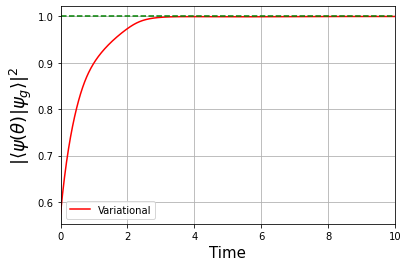

(0.0, 10.0)

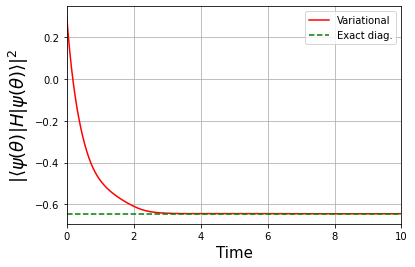

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
